In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import random
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor
import warnings
warnings.simplefilter('ignore')

In [3]:
def show_image(val):
    return '<a href="{}"><img src="{}" width=200></img></a>'.format(val, val)

In [4]:
df = pd.read_csv('competitors_data.csv')
df = df.drop_duplicates()
df = df.dropna(subset=['caracteristics', 'price'])
df['cat_2'] = df['cat_2'].apply(lambda x: str(x).strip())
df['cat_2'] = df['cat_2'].apply(lambda x: x if len(x) > 1 else '')
df['cat_1'] = df['cat_1'].apply(lambda x: x if len(x) > 1 else '')
df['cat_1'] = df['cat_1'].apply(lambda x: str(x).replace('ZonaSporta', '').replace('арт', '').replace('Читать обзор на товар', '').strip())
df['caracteristics'] = df['caracteristics'].apply(lambda x: str(x).replace(':: ', ': ').replace('\xa0', ''))
df = df.reset_index(drop=True)
df.iloc[2000:2001].style.format({'url': show_image, **{'width': '200px'}})

,title,article,price,cat_1,cat_2,cat_3,description,caracteristics,source,date,url
2000,Беговая дорожка AeroFIT iX3-T,61315,126190,,Беговые дорожки,AeroFIT,"Купить беговую дорожку AeroFIT iX3-T в нашем интернет-магазине можно по самой выгодной цене, обратившись к нашим специалистам. Так же на нашем сайте собрана самая большая база отзывов, фото и видео о беговых дорожках от наших клиентов. Если хотите заказать товар недорого и с бесплатной доставкой и сборкой, тоже обращайтесь к нашим специалистам, подберём самое лучшее, что есть в России. Звоните, мы рады каждому обращению: 8 (800) 333-47-80 Беговая дорожка AeroFIT iX3-T - отличный вариант тренажёра, который будет способствовать поддержанию прекрасного самочувствия и укрепления здоровья. На данной модели тренировки проходят с наивысшим кофортом за счёт функционала беговой дорожки. Максимальный вес пользователя 180 кг.","Макс. вес пользователя: 180 кг Система нагрузки: электрическая Минимальная скорость полотна: 0.8 км/ч Максимальная скорость полотна: 22 км/ч Мощность двигателя: 3.5 л.с. Регулировка угла наклона Максимальный угол наклона: 15 ° Система амортизации Тренировочных программ: 15 шт Пульсозависимые программы Информирование: время тренировки, дистанция, скорость, измерение пульса, расход калорий, наклон, профиль Дополнительно: управление на рукоятках, ключ аварийной остановки, цветной дисплей, подставка для планшета Страна происхождения бренда: Нидерланды Размер полотна (ДхШ): 153x55 см Габариты: Габариты: 208x92x141 см Вес: 160 кг",www.zonasporta.ru,2023-09-02,


In [5]:
df['source'].value_counts()

www.zonasporta.ru    1627
www.mir-sporta.ru     825
www.domsporta.ru      556
www.sportdoma.ru      392
www.ozon.ru           287
Name: source, dtype: int64

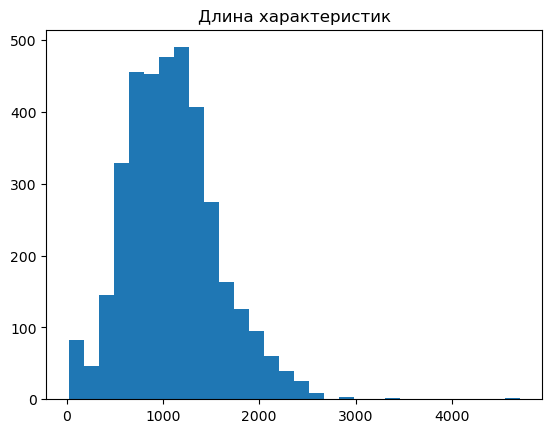

In [6]:
plt.title('Длина характеристик')
plt.hist(list(map(len, df['caracteristics'])), bins=30)
plt.show()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           3687 non-null   object
 1   article         2766 non-null   object
 2   price           3687 non-null   int64 
 3   cat_1           3687 non-null   object
 4   cat_2           3687 non-null   object
 5   cat_3           3671 non-null   object
 6   description     3606 non-null   object
 7   caracteristics  3687 non-null   object
 8   source          3687 non-null   object
 9   date            3687 non-null   object
 10  url             3399 non-null   object
dtypes: int64(1), object(10)
memory usage: 317.0+ KB


In [8]:
df.isnull().sum()

title               0
article           921
price               0
cat_1               0
cat_2               0
cat_3              16
description        81
caracteristics      0
source              0
date                0
url               288
dtype: int64

In [9]:
df1 = pd.read_csv('comparable_data.csv', index_col = 0)
df1 = df1.dropna(subset=['caracteristics', 'price', 'article'])
df1 = df1.drop_duplicates()
df1['cat_2'] = df1['cat_2'].apply(lambda x: str(x).strip())
df1['cat_1'] = df1['cat_1'].apply(lambda x: str(x).replace('Тренажры', 'Тренажеры'))
df1['caracteristics'] = df1['caracteristics'].apply(lambda x: str(x).replace('Читать обзор на товар', '').strip())
df1['price'] = df1['price'].astype(int)
df1 = df1.reset_index(drop=True)
df1[100:101].head(3).style.format({'url': show_image, **{'width': '200px'}})

,title,article,price,cat_1,cat_2,cat_3,url,description,caracteristics,source,date
100,Беговая дорожка Titanium Masters Physiotech A360,400123365,69990,Тренажеры,Беговые дорожки,Titanium,,"Беговая дорожка Titanium Masters Physiotech A360 оснащена дополнительными кнопками управления на поручнях. Там же расположены датчики пульса. Можно отслеживать их показания на большом электронном дисплее. Тренажер подходит для спортсменов, чей вес не превышает 140 кг. Размеры бегового полотна — 132х47 см. Модель оборудована двигателем мощностью 3 л.с, разгоняющим устройство до 18 км/ч. Возможно изменять угол наклона для увеличения или уменьшения желаемой нагрузки. Тренажер складывается пополам и в таком положении занимает в два раза меньше места. Для транспортировки беговой дорожки по квартире предусмотрены колесики. Габариты — 178х76х29,5 см. Вес — 64 кг.",Гарантия 1 год Страна Китай Длина полотна 132 см Максимальный вес пользователя 140 кг Ширина полотна 47 см Максимальная скорость 18 км/ч Регулировка угла наклона Да Цифровой дисплей Да Индикация дистанции Да Индикация выбранной скорости Да Индикация расхода калорий Да Индикация пульса Да Колесики для перемещения Да Питание от сети 220 В Да Глубина 178 см Ширина 76 см Высота 29.5 см Вес 64.22 кг Цвет черный,www.mvideo.ru,2023-08-16


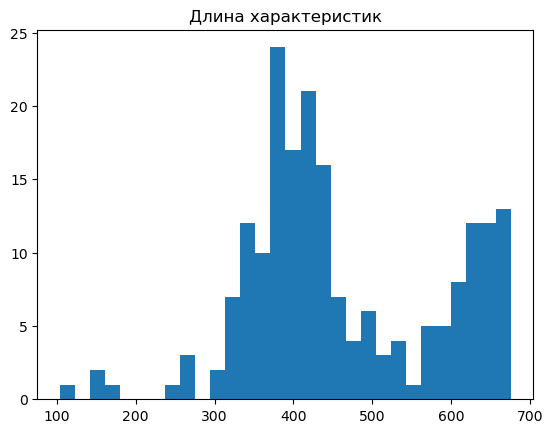

In [10]:
plt.title('Длина характеристик')
plt.hist(list(map(len, df1['caracteristics'])), bins=30)
plt.show()

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           197 non-null    object
 1   article         197 non-null    int64 
 2   price           197 non-null    int32 
 3   cat_1           197 non-null    object
 4   cat_2           197 non-null    object
 5   cat_3           197 non-null    object
 6   url             197 non-null    object
 7   description     156 non-null    object
 8   caracteristics  197 non-null    object
 9   source          197 non-null    object
 10  date            197 non-null    object
dtypes: int32(1), int64(1), object(9)
memory usage: 16.3+ KB


In [12]:
df1.isnull().sum()

title              0
article            0
price              0
cat_1              0
cat_2              0
cat_3              0
url                0
description       41
caracteristics     0
source             0
date               0
dtype: int64

In [13]:
own_articles = list(df1['article'])

# Варианты векторного представления:

1. Только названия товаров (title)
2. Название + 3 категории
3. 3 категории + характеристики
4. Название товаров + характеристики
5. Только характеристики
6. Название + 3 категории + характеристики

In [14]:
from sentence_transformers import SentenceTransformer
from scipy import sparse

model = SentenceTransformer('sentence-transformers/LaBSE')

In [15]:
data_vect_lst = []
competitors_vect_lst = []

txt_combinations = [['title'],['cat_1','cat_2','cat_3','title'],['cat_1','cat_2','cat_3', 'caracteristics'],
                  ['title', 'caracteristics'], ['caracteristics'], ['title','cat_1','cat_2','cat_3', 'caracteristics']]

combo_names = ['Title_only', 'Title + cat', 'Cat + character', 'Title + character', 'Only character', 'Title + cat + character']

for i in txt_combinations:
    data_vect = model.encode(df1[i].astype(str).agg(' '.join, axis=1).tolist(), normalize_embeddings=True)
    data_vect_lst.append(data_vect)
    competitors_vect = model.encode(df[i].astype(str).agg(' '.join, axis=1).tolist(), normalize_embeddings=True)
    competitors_vect_lst.append(competitors_vect)

print(len(data_vect_lst))
print(len(competitors_vect_lst))

6
6


In [16]:
def search_similar(article, data, competitors,data_vect, competitors_vect, sim_threshhold):
    """article - item to review from own dat
       data - dataframe with own products
       competitors - dataframe with competitors' products
       data_vect - data in vectorized form
       competitors_vect - competitors data in vectorized form
       sim_threshhold - min similarity score to be inlcuded in recommendation"""

    #print(f'Article to be reviewed: {article}')
    query = data[data['article'] == article]
    
    data_emb = sparse.csr_matrix(data_vect)
    competitors_emb = sparse.csr_matrix(competitors_vect)

    #display(query[['title','price','caracteristics', 'url']] .style.format({'url': show_image, **{'width': '100px'}}))
    index = query.index[0]
    

    similarity = cosine_similarity(data_emb[index], competitors_emb).flatten()
    ind = np.argwhere(similarity > sim_threshhold)

    if ind.shape[0] == 0:
        print('No items to compare in the sampling!')

    else:
        scores = similarity[similarity > sim_threshhold]
        match = sorted(zip(scores, ind.tolist()), reverse=True)
        temp = pd.DataFrame()
        temp_lst = []
        temp = temp.append(competitors.iloc[match[0][1]][['title', 'price','caracteristics', 'url']])
        temp_lst.append(round(match[0][0], 2))
       
        try:
            temp = temp.append(competitors.iloc[match[1][1]][['title', 'price','caracteristics', 'url']])
            temp_lst.append(round(match[1][0], 2))           
        except:
            print('No top 2 identified!')
            
        try:
            temp = temp.append(competitors.iloc[match[2][1]][['title', 'price','caracteristics', 'url']])
            temp_lst.append(round(match[2][0], 2))           
        except:
            print('No top 3 identified!')
    temp['sim_score'] = temp_lst
    display(temp.style.format({'url': show_image, **{'width': '200px'}}))

In [17]:
query = df1[df1['article'] == 400081342]
display(query[['title','price','caracteristics', 'url']] .style.format({'url': show_image, **{'width': '200px'}}))
for ind, item  in enumerate(combo_names):
    print(f'Similar search results for text combination {item}:')
    
    search_similar(article = 400081342, 
               data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0.5)

,title,price,caracteristics,url
188,Степпер Bronze Gym ST700M,125990,"Гарантия 3 года Страна Китай Обратите внимание держатель для мобильных устройств Удачное решение Педали прорезиненные, увеличенного размера Важная особенность Маховик, весом 15 кг Пользователи оценят многофункциональный LСD дисплей Хорошо придумано сенсорные датчики пульса на фиксированных поручнях Максимальный вес пользователя 160 кг Количество уровней нагрузки 15 Система нагружения магнитная Особенности Высота шага 400 мм Тип степпера классический Цифровой дисплей Да Индикация времени тренировки Да Индикация дистанции Да Индикация пульса Да Индикация расхода калорий Да Индикация ритма, шаг/мин Да Количество шагов за тренировку Да Индикация температуры в помещении Да",


Similar search results for text combination Title_only:


,title,price,caracteristics,url,sim_score
2406,Степпер коммерческий Bronze Gym ST700M,119990,"Назначение: профессиональное Рама: высокопрочная, износостойкая с двухслойной покраской Система нагружения: магнитная Кол-во уровней нагрузки: 15 Маховик: 15 кг Педали: прорезиненные антискользящие, увеличенного размера Высота шага: 400 мм Измерение пульса: сенсорные датчики на фиксированных поручнях Консоль: многофункциональный LСD дисплей, отображающий 5 параметров тренировки одновременно Показания консоли: время, счет, дистанция, пульс, темп/мин, фитнес тест, жироанализатор, метаболические индексы (BMI, BMR), температура в помещении Мультимедиа: нет Интерне:т нет Язык(и) интерфейса: английский Подставка под телефон/планшет: есть Держатель бутылки: есть Вентилятор: нет Складывание: нет Компенсаторы неровностей пола: есть Транспортировочные ролики: есть Макс. вес пользователя: 160 кг Питание: батарейки (не требует подключения к эл. сети) Энергосбережение: есть Гарантия: 3 года Производитель: BRONZE GYM Страна изготовления: КНР Габариты: Размер в рабочем состоянии (Д*Ш*В): 145,5*80,5*157 см Вес нетто: 84,5 кг Вес брутто: 96,5 кг Размер в упаковке (Д*Ш*В): 147*57*90 см (упаковка 1 шт. в 1 коробке)",,0.930000
295,Степпер коммерческий Bronze Gym ST700M,125990,"Страна изготовления:Китай Возможность профессионального использования:Да Торговая марка:Bronze Gym Вес, кг:84.5 Габариты (ДхШхВ), cм:145,5x80,5x157 Гарантийный срок, мес: 36 Вес с упаковкой, кг:96.5 Габариты упаковки (ДхШхВ), см:147x57x90 Общий объем товара, м3:0.7541: Датчики и показатели:Измерение времени, мин:Да Отображение расхода калорий: Да Отображение частоты шагания: Да Отображение темпа: да Измерение пульса: Да: Общие характеристики:Министеппер: Нет Тип: классические Складная конструкция: Нет Количество уровней нагрузки: 15 Максимальный вес пользователя, кг: 160 Автономная работа: Да Тип автономного питания: батарейки Вес маховика, кг:15: Дополнительная нформация:Наличие поручней:есть Транспортировочные ролики/колеса: да:",,0.930000
2409,Степпер-кросстрейнер с автонаклоном Bronze Gym ST800M,173990,"Назначение: профессиональное Рама: высокопрочная Система нагружения: аэромагнитная Кол-во уровней нагрузки: 24 Педали: антискользящие, увеличенного размера Высота шага: 300 мм Измерение пульса: сенсорные датчики на поручнях Консоль: многофункциональный LED дисплей с точечной матрицей + 7 дополнительных информационных LED окон с подсветкой Показания консоли: время, скорость, дистанция, уровень нагрузки, уровень наклона, калории, пульс, темп, Ватт, фитнес тест, жироанализатор Кол-во программ: 23 Спецификации программ: быстрый старт, ручной режим, 12 предустановленных программ, 4 пользовательские, 3 пульсозависимые, программа постоянной мощности (Ватт) Мультимедиа: нет Интернет: нет Язык(и) интерфейса: английский Вентилятор: нет Складывание: нет Макс. вес пользователя: 160 кг Питание: сеть 220 Вольт Производитель: Fitathlon Group (Германия) Страна изготовления: КНР Габариты: Размер в рабочем состоянии (ДхШхВ): 166х88х178 см Вес нетто: 116 кг Вес брутто: 133 кг Размер в упаковке (ДхШхВ): 143х50х104 см (упаковка 1 шт. в 1 коробке)",,0.880000


Similar search results for text combination Title + cat:


,title,price,caracteristics,url,sim_score
295,Степпер коммерческий Bronze Gym ST700M,125990,"Страна изготовления:Китай Возможность профессионального использования:Да Торговая марка:Bronze Gym Вес, кг:84.5 Габариты (ДхШхВ), cм:145,5x80,5x157 Гарантийный срок, мес: 36 Вес с упаковкой, кг:96.5 Габариты упаковки (ДхШхВ), см:147x57x90 Общий объем товара, м3:0.7541: Датчики и показатели:Измерение времени, мин:Да Отображение расхода калорий: Да Отображение частоты шагания: Да Отображение темпа: да Измерение пульса: Да: Общие характеристики:Министеппер: Нет Тип: классические Складная конструкция: Нет Количество уровней нагрузки: 15 Максимальный вес пользователя, кг: 160 Автономная работа: Да Тип автономного питания: батарейки Вес маховика, кг:15: Дополнительная нформация:Наличие поручней:есть Транспортировочные ролики/колеса: да:",,0.960000
2406,Степпер коммерческий Bronze Gym ST700M,119990,"Назначение: профессиональное Рама: высокопрочная, износостойкая с двухслойной покраской Система нагружения: магнитная Кол-во уровней нагрузки: 15 Маховик: 15 кг Педали: прорезиненные антискользящие, увеличенного размера Высота шага: 400 мм Измерение пульса: сенсорные датчики на фиксированных поручнях Консоль: многофункциональный LСD дисплей, отображающий 5 параметров тренировки одновременно Показания консоли: время, счет, дистанция, пульс, темп/мин, фитнес тест, жироанализатор, метаболические индексы (BMI, BMR), температура в помещении Мультимедиа: нет Интерне:т нет Язык(и) интерфейса: английский Подставка под телефон/планшет: есть Держатель бутылки: есть Вентилятор: нет Складывание: нет Компенсаторы неровностей пола: есть Транспортировочные ролики: есть Макс. вес пользователя: 160 кг Питание: батарейки (не требует подключения к эл. сети) Энергосбережение: есть Гарантия: 3 года Производитель: BRONZE GYM Страна изготовления: КНР Габариты: Размер в рабочем состоянии (Д*Ш*В): 145,5*80,5*157 см Вес нетто: 84,5 кг Вес брутто: 96,5 кг Размер в упаковке (Д*Ш*В): 147*57*90 см (упаковка 1 шт. в 1 коробке)",,0.950000
309,Степпер-кросстрайнер с автонаклоном Bronze Gym ST800M,173990,"Страна изготовления:Китай Возможность профессионального использования:Да Торговая марка:Bronze Gym Вес, кг:116 Габариты (ДхШхВ), cм:166x88x178 Вес с упаковкой, кг:133 Габариты упаковки (ДхШхВ), см:143x50x104 Общий объем товара, м3:0.7436: Датчики и показатели:Измерение времени, мин:Да Отображение расхода калорий: Да Отображение темпа: да Измерение пульса: Да: Общие характеристики:Тип: классические Складная конструкция: Нет Количество уровней нагрузки: 24 Максимальный вес пользователя, кг: 150 Автономная работа: Нет: Дополнительная нформация:Наличие поручней:есть Эспандеры: Нет: Программы:Количество программ тренировки: 23 Количество пульсозависимых программ: 3:",,0.930000


Similar search results for text combination Cat + character:


,title,price,caracteristics,url,sim_score
2406,Степпер коммерческий Bronze Gym ST700M,119990,"Назначение: профессиональное Рама: высокопрочная, износостойкая с двухслойной покраской Система нагружения: магнитная Кол-во уровней нагрузки: 15 Маховик: 15 кг Педали: прорезиненные антискользящие, увеличенного размера Высота шага: 400 мм Измерение пульса: сенсорные датчики на фиксированных поручнях Консоль: многофункциональный LСD дисплей, отображающий 5 параметров тренировки одновременно Показания консоли: время, счет, дистанция, пульс, темп/мин, фитнес тест, жироанализатор, метаболические индексы (BMI, BMR), температура в помещении Мультимедиа: нет Интерне:т нет Язык(и) интерфейса: английский Подставка под телефон/планшет: есть Держатель бутылки: есть Вентилятор: нет Складывание: нет Компенсаторы неровностей пола: есть Транспортировочные ролики: есть Макс. вес пользователя: 160 кг Питание: батарейки (не требует подключения к эл. сети) Энергосбережение: есть Гарантия: 3 года Производитель: BRONZE GYM Страна изготовления: КНР Габариты: Размер в рабочем состоянии (Д*Ш*В): 145,5*80,5*157 см Вес нетто: 84,5 кг Вес брутто: 96,5 кг Размер в упаковке (Д*Ш*В): 147*57*90 см (упаковка 1 шт. в 1 коробке)",,0.820000
3589,Степпер SportsArt S715,674340,"Тип степпера Классический Опции для рук Неподвижные поручни Класс тренажера Коммерческий Максимальный вес пользователя, кг 225 Приборная панель Описание дисплея Матричный Количество программ, шт 12 Показания дисплея Измерение времени, Отображение расхода калорий, Отображение частоты шагания, Измерение пульса Способ измерения пульса Сенсорные датчики Описание тренировочных программпроизвольная, интервальная, пользовательская, быстрый старт, холмы, кардио H R C, сброс веса H R C Дополнительные Тип питания Не требует подключения к сети (встроенный генератор)Габариты и вес Длина товара, см 146 Ширина товара, см 79 Высота товара, см 183 Вес товара, кг 106 Производитель Бренд Sports Art Страна бренда С Ш А Производство Тайвань Гарантиядо 3 лет",,0.790000
3583,Степпер BRONZE GYM ST700M,125990,"Тип степпера Классический Опции для рук Неподвижные поручни Класс тренажера Коммерческий Система нагружения Магнитная Уровни нагрузки, шт 15 Вес маховика, кг 15 Максимальный вес пользователя, кг 160 Высота шага, см 40 Приборная панель Описание дисплеямногофункциональный L С D дисплей, отображающий 5 параметров тренировки одновременно Способ измерения пульса Сенсорные датчики Отображение текущей скорости Да Отображение времени тренировки Да Отображение пульса Да Дополнительные Описание рамывысокопрочная, износостойкая с двухслойной покраской Тип питания Не требует подключения к сети, От батареек Характеристики педалейпрорезиненные антискользящие, увеличенного размера Транспортировочные ролики Да Компенсаторы неровности пола Да Габариты и вес Длина товара, см 145.5 Ширина товара, см 80.5 Высота товара, см 157 Длина в упаковке, см 147 Ширина в упаковке, см 57 Высота в упаковке, см 90 Вес товара, кг 84.5 Вес в упаковке, кг 96.5 Производитель Бренд B R O N Z E G Y M Производство К Н Р Гарантия 3 года",,0.780000


Similar search results for text combination Title + character:


,title,price,caracteristics,url,sim_score
2406,Степпер коммерческий Bronze Gym ST700M,119990,"Назначение: профессиональное Рама: высокопрочная, износостойкая с двухслойной покраской Система нагружения: магнитная Кол-во уровней нагрузки: 15 Маховик: 15 кг Педали: прорезиненные антискользящие, увеличенного размера Высота шага: 400 мм Измерение пульса: сенсорные датчики на фиксированных поручнях Консоль: многофункциональный LСD дисплей, отображающий 5 параметров тренировки одновременно Показания консоли: время, счет, дистанция, пульс, темп/мин, фитнес тест, жироанализатор, метаболические индексы (BMI, BMR), температура в помещении Мультимедиа: нет Интерне:т нет Язык(и) интерфейса: английский Подставка под телефон/планшет: есть Держатель бутылки: есть Вентилятор: нет Складывание: нет Компенсаторы неровностей пола: есть Транспортировочные ролики: есть Макс. вес пользователя: 160 кг Питание: батарейки (не требует подключения к эл. сети) Энергосбережение: есть Гарантия: 3 года Производитель: BRONZE GYM Страна изготовления: КНР Габариты: Размер в рабочем состоянии (Д*Ш*В): 145,5*80,5*157 см Вес нетто: 84,5 кг Вес брутто: 96,5 кг Размер в упаковке (Д*Ш*В): 147*57*90 см (упаковка 1 шт. в 1 коробке)",,0.810000
3583,Степпер BRONZE GYM ST700M,125990,"Тип степпера Классический Опции для рук Неподвижные поручни Класс тренажера Коммерческий Система нагружения Магнитная Уровни нагрузки, шт 15 Вес маховика, кг 15 Максимальный вес пользователя, кг 160 Высота шага, см 40 Приборная панель Описание дисплеямногофункциональный L С D дисплей, отображающий 5 параметров тренировки одновременно Способ измерения пульса Сенсорные датчики Отображение текущей скорости Да Отображение времени тренировки Да Отображение пульса Да Дополнительные Описание рамывысокопрочная, износостойкая с двухслойной покраской Тип питания Не требует подключения к сети, От батареек Характеристики педалейпрорезиненные антискользящие, увеличенного размера Транспортировочные ролики Да Компенсаторы неровности пола Да Габариты и вес Длина товара, см 145.5 Ширина товара, см 80.5 Высота товара, см 157 Длина в упаковке, см 147 Ширина в упаковке, см 57 Высота в упаковке, см 90 Вес товара, кг 84.5 Вес в упаковке, кг 96.5 Производитель Бренд B R O N Z E G Y M Производство К Н Р Гарантия 3 года",,0.800000
2483,Степпер BRONZE GYM ST700M,125990,"Тип степпера:профессиональный Система нагружения:магнитная Кол-во уровней нагрузки:15 Педали:прорезиненные антискользящие, увеличенного размера Высота шага:400 мм Измерение пульса:сенсорные датчики на фиксированныхпоручнях Консоль:многофункциональный L СD дисплей,отображающий 5 параметров тренировкиодновременно Показания консоли:время, счет, дистанция, пульс, темп/мин, фитнес тест, жироанализатор, метаболические индексы (BMI, BMR), температура в помещении Многоязычный интерфейс:английский Интеграция и Мультимедиа:нет Питание:батарейки (не требует подключения к эл. сети)Складывание:нет Габариты (Дх Шх В):в рабочем состоянии 145,5 x 80,5 x 157 см; в упаковке 147 х 57 х 90 см Вес:нетто 84.5 кг.; брутто 96.5 кг.Максимальный вес пользователя:160 кг Рама:высокопрочная, износостойкая с двухслойной покраской Дополнительные характеристики:вентилятор - нет Гарантия:3 года Производитель:BRONZE GYM Страна изготовления:К Н Р",,0.780000


Similar search results for text combination Only character:


,title,price,caracteristics,url,sim_score
3583,Степпер BRONZE GYM ST700M,125990,"Тип степпера Классический Опции для рук Неподвижные поручни Класс тренажера Коммерческий Система нагружения Магнитная Уровни нагрузки, шт 15 Вес маховика, кг 15 Максимальный вес пользователя, кг 160 Высота шага, см 40 Приборная панель Описание дисплеямногофункциональный L С D дисплей, отображающий 5 параметров тренировки одновременно Способ измерения пульса Сенсорные датчики Отображение текущей скорости Да Отображение времени тренировки Да Отображение пульса Да Дополнительные Описание рамывысокопрочная, износостойкая с двухслойной покраской Тип питания Не требует подключения к сети, От батареек Характеристики педалейпрорезиненные антискользящие, увеличенного размера Транспортировочные ролики Да Компенсаторы неровности пола Да Габариты и вес Длина товара, см 145.5 Ширина товара, см 80.5 Высота товара, см 157 Длина в упаковке, см 147 Ширина в упаковке, см 57 Высота в упаковке, см 90 Вес товара, кг 84.5 Вес в упаковке, кг 96.5 Производитель Бренд B R O N Z E G Y M Производство К Н Р Гарантия 3 года",,0.810000
2406,Степпер коммерческий Bronze Gym ST700M,119990,"Назначение: профессиональное Рама: высокопрочная, износостойкая с двухслойной покраской Система нагружения: магнитная Кол-во уровней нагрузки: 15 Маховик: 15 кг Педали: прорезиненные антискользящие, увеличенного размера Высота шага: 400 мм Измерение пульса: сенсорные датчики на фиксированных поручнях Консоль: многофункциональный LСD дисплей, отображающий 5 параметров тренировки одновременно Показания консоли: время, счет, дистанция, пульс, темп/мин, фитнес тест, жироанализатор, метаболические индексы (BMI, BMR), температура в помещении Мультимедиа: нет Интерне:т нет Язык(и) интерфейса: английский Подставка под телефон/планшет: есть Держатель бутылки: есть Вентилятор: нет Складывание: нет Компенсаторы неровностей пола: есть Транспортировочные ролики: есть Макс. вес пользователя: 160 кг Питание: батарейки (не требует подключения к эл. сети) Энергосбережение: есть Гарантия: 3 года Производитель: BRONZE GYM Страна изготовления: КНР Габариты: Размер в рабочем состоянии (Д*Ш*В): 145,5*80,5*157 см Вес нетто: 84,5 кг Вес брутто: 96,5 кг Размер в упаковке (Д*Ш*В): 147*57*90 см (упаковка 1 шт. в 1 коробке)",,0.800000
38,"Беговая дорожка Dfit Pacifica X NEW, для дома, электрическая, складная, до 130 кг.",37298,"Класс тренажера Домашний Максимальная скорость, км/ч 14.8 Максимальный вес пользователя, кг 130 Измерительные датчики Время, Дистанция, Пульс, Расход калорий, Скорость Питание тренажера Сеть 220 Вольт Целевая аудитория Взрослая Регулировка угла наклона бегового полотна Ручная Кол-во программ 15 Макс. угол наклона полотна, % 3 Страна-изготовитель Китай Габариты и вес Ширина бегового полотна, см 45 Длина бегового полотна, см 120 Ширина, см 72 Длина, см 160 Вес товара, г 45000 Высота, см 116 Дополнительные Тип Беговая дорожка Форма поставки В разобранном виде Бренд Dfit Амортизация 8 эластомеров (Shock Absorbing System) Дисплей LCD 5 дюймов Гарантийный срок 2 года Система нагрузки беговой дорожки Электрическая Особенности тренажеров: Антискользящее покрытие, Складная конструкция, Целевые тренировки, Вертикальное хранение, Компенсатор неровности пола, Транспортировочные ролики",,0.770000


Similar search results for text combination Title + cat + character:


,title,price,caracteristics,url,sim_score
2406,Степпер коммерческий Bronze Gym ST700M,119990,"Назначение: профессиональное Рама: высокопрочная, износостойкая с двухслойной покраской Система нагружения: магнитная Кол-во уровней нагрузки: 15 Маховик: 15 кг Педали: прорезиненные антискользящие, увеличенного размера Высота шага: 400 мм Измерение пульса: сенсорные датчики на фиксированных поручнях Консоль: многофункциональный LСD дисплей, отображающий 5 параметров тренировки одновременно Показания консоли: время, счет, дистанция, пульс, темп/мин, фитнес тест, жироанализатор, метаболические индексы (BMI, BMR), температура в помещении Мультимедиа: нет Интерне:т нет Язык(и) интерфейса: английский Подставка под телефон/планшет: есть Держатель бутылки: есть Вентилятор: нет Складывание: нет Компенсаторы неровностей пола: есть Транспортировочные ролики: есть Макс. вес пользователя: 160 кг Питание: батарейки (не требует подключения к эл. сети) Энергосбережение: есть Гарантия: 3 года Производитель: BRONZE GYM Страна изготовления: КНР Габариты: Размер в рабочем состоянии (Д*Ш*В): 145,5*80,5*157 см Вес нетто: 84,5 кг Вес брутто: 96,5 кг Размер в упаковке (Д*Ш*В): 147*57*90 см (упаковка 1 шт. в 1 коробке)",,0.820000
3583,Степпер BRONZE GYM ST700M,125990,"Тип степпера Классический Опции для рук Неподвижные поручни Класс тренажера Коммерческий Система нагружения Магнитная Уровни нагрузки, шт 15 Вес маховика, кг 15 Максимальный вес пользователя, кг 160 Высота шага, см 40 Приборная панель Описание дисплеямногофункциональный L С D дисплей, отображающий 5 параметров тренировки одновременно Способ измерения пульса Сенсорные датчики Отображение текущей скорости Да Отображение времени тренировки Да Отображение пульса Да Дополнительные Описание рамывысокопрочная, износостойкая с двухслойной покраской Тип питания Не требует подключения к сети, От батареек Характеристики педалейпрорезиненные антискользящие, увеличенного размера Транспортировочные ролики Да Компенсаторы неровности пола Да Габариты и вес Длина товара, см 145.5 Ширина товара, см 80.5 Высота товара, см 157 Длина в упаковке, см 147 Ширина в упаковке, см 57 Высота в упаковке, см 90 Вес товара, кг 84.5 Вес в упаковке, кг 96.5 Производитель Бренд B R O N Z E G Y M Производство К Н Р Гарантия 3 года",,0.810000
2409,Степпер-кросстрейнер с автонаклоном Bronze Gym ST800M,173990,"Назначение: профессиональное Рама: высокопрочная Система нагружения: аэромагнитная Кол-во уровней нагрузки: 24 Педали: антискользящие, увеличенного размера Высота шага: 300 мм Измерение пульса: сенсорные датчики на поручнях Консоль: многофункциональный LED дисплей с точечной матрицей + 7 дополнительных информационных LED окон с подсветкой Показания консоли: время, скорость, дистанция, уровень нагрузки, уровень наклона, калории, пульс, темп, Ватт, фитнес тест, жироанализатор Кол-во программ: 23 Спецификации программ: быстрый старт, ручной режим, 12 предустановленных программ, 4 пользовательские, 3 пульсозависимые, программа постоянной мощности (Ватт) Мультимедиа: нет Интернет: нет Язык(и) интерфейса: английский Вентилятор: нет Складывание: нет Макс. вес пользователя: 160 кг Питание: сеть 220 Вольт Производитель: Fitathlon Group (Германия) Страна изготовления: КНР Габариты: Размер в рабочем состоянии (ДхШхВ): 166х88х178 см Вес нетто: 116 кг Вес брутто: 133 кг Размер в упаковке (ДхШхВ): 143х50х104 см (упаковка 1 шт. в 1 коробке)",,0.780000


In [18]:
query = df1[df1['article'] == 400123365]
display(query[['title','price','caracteristics', 'url']] .style.format({'url': show_image, **{'width': '200px'}}))
for ind, item  in enumerate(combo_names):
    print(f'Similar search results for text combination {item}:')
    
    search_similar(article = 400123365, 
               data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0.5)

,title,price,caracteristics,url
100,Беговая дорожка Titanium Masters Physiotech A360,69990,Гарантия 1 год Страна Китай Длина полотна 132 см Максимальный вес пользователя 140 кг Ширина полотна 47 см Максимальная скорость 18 км/ч Регулировка угла наклона Да Цифровой дисплей Да Индикация дистанции Да Индикация выбранной скорости Да Индикация расхода калорий Да Индикация пульса Да Колесики для перемещения Да Питание от сети 220 В Да Глубина 178 см Ширина 76 см Высота 29.5 см Вес 64.22 кг Цвет черный,


Similar search results for text combination Title_only:


,title,price,caracteristics,url,sim_score
3320,Беговая дорожка Titanium Masters Physiotech A360,72191,"Тип дорожки Электрическая Класс тренажера Домашний Конструкция тренажера Складная Описание электродвигателя Fuji Electric (постоянный ток)Мощность двигателя, л.с. 3 Максимальный вес пользователя, кг 140 Длина бегового полотна, см 132 Ширина бегового полотна, см 47 Тип регулировки угла наклона Автоматическая Угол наклона 0 - 18 Максимальная скорость, км/ч 18 Минимальная скорость, км/ч 1 Наличие амортизации Да Система амортизации 4 полноразмерных динамических эластомера V C S™ + 4 среднеразмерных динамических эластомера V C S™ + 4 силиконовых эластомера V A T™ + 2 силиконовые подушки Система складывания Двухфазная гидравлика easy-D R O P™Приборная панель Описание дисплея L C D-дисплеей диагональю 5 дюймов ( 12 , 7 см) c сенсорными клавишами Язык интерфейса Английский Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Программы тренировок Количество программ, шт 18 Удобства Сенсорные датчики Да Дополнительные Питание тренажера От сети 220 Вольт Пиковая мощность двигателя, л.с. 5.1 Цвет Черный Габариты и вес Длина товара, см 164 Ширина товара, см 74 Высота товара, см 129 Вес товара, кг 53 Длина в сложенном состоянии, см 96 Ширина в сложенном состоянии, см 74 Высота в сложенном состоянии, см 143 Производитель Бренд Titanium Гарантия 5 лет Производство К Н Р",,1.000000
2802,Беговая дорожка Titanium Masters Physiotech A360,71990,"Тип дорожки:для домашнего использования Скорость:1-18 км/ч Мощность двигателя:3,0 л.с. Fuji Electric (постоянный ток)Пиковая мощность двигателя:5,1 л.с.Беговое полотно:1,8 мм, многослойное Habasit N НT-218 Размер бегового полотна (Дх Ш):132 х 47 см Регулировка угла наклона:электрическая Наклон бегового полотна:0 - 18%Дека:18 мм, парафинированная Система амортизации:4 полноразмерных динамических эластомера VCS™ + 4 среднеразмерных динамических эластомера VCS™ + 4 силиконовых эластомера VAT™ + 2 силиконовые подушки Измерение пульса:сенсорные датчики Консоль:голубой LCD-дисплей диагональю 5 дюймов (12,7 см) c сенсорными клавишами Показания консоли:время, дистанция, скорость, калории, угол наклона, пульс Кол-во программ:15 предустановленных программ + ручной режим Питание:сеть 220 Вольт Складывание:двухфазная гидравлика easy-DROP™Габариты (Дх Шх В):в рабочем состоянии 164 х 74 х 129 см; в сложенном 96 х 74 х 143 см; в упаковке 178 х 76 х 29,5 см Вес:нетто 53 кг.; брутто 60 кг.Максимальный вес пользователя:140 кг Дополнительные характеристики:транспортировочные ролики, управление на поручнях, энергосбережение, подставка под мобильное устройство Гарантия:5 лет Производитель:Bradex Corp. (Германия-Израиль)Страна изготовления:К Н Р",,1.000000
1861,Беговая дорожка Titanium Masters Physiotech A360,75990,"Назначение: домашнее Беговое полотно:1,8 мм, многослойное Habasit NНT-218 Вентилятор:нет Двигатель:3,0 л.с. Fuji Electric (постоянный ток) Дека:18 мм, парафинированная Зарядка мобильного устройства:нет Измерение пульса:нет Интеграция:нет Интернет:нет Компенсаторы неровностей пола:нет Консоль:голубой LCD-дисплей диагональю 5 дюймов (12,7 см) c сенсорными клавишами Максимальный вес пользователя:140 кг Мультимедиа:нет Общее количество программ:15 Пиковая мощность:5,1 л.с. Питание:сеть 220 Вольт Подставка под мобильное устройство:есть Показания консоли:время, дистанция, скорость, калории, угол наклона, пульс Пользовательские программы:нет Производитель:Bradex Corp. (Германия-Израиль) Пульсозависимые программы:нет Размер бегового полотна:132*47 см Разъемы и передача данных:нет Регулировка угла наклона:электрическая Ручной режим:есть Система амортизации:4 полноразмерных динамических эластомера VCS™ + 4 среднеразмерных динамических эластомера VCS™ + 4 силиконовых эластомера VAT™ + 2 силиконовые подушки Складывание:двухфазная гидравлика easy-DROP™ Скорость:1-18 км/ч Страна изготовления:КНР Транспортировочные ролики:есть 

Similar search results for text combination Title + cat:


,title,price,caracteristics,url,sim_score
3320,Беговая дорожка Titanium Masters Physiotech A360,72191,"Тип дорожки Электрическая Класс тренажера Домашний Конструкция тренажера Складная Описание электродвигателя Fuji Electric (постоянный ток)Мощность двигателя, л.с. 3 Максимальный вес пользователя, кг 140 Длина бегового полотна, см 132 Ширина бегового полотна, см 47 Тип регулировки угла наклона Автоматическая Угол наклона 0 - 18 Максимальная скорость, км/ч 18 Минимальная скорость, км/ч 1 Наличие амортизации Да Система амортизации 4 полноразмерных динамических эластомера V C S™ + 4 среднеразмерных динамических эластомера V C S™ + 4 силиконовых эластомера V A T™ + 2 силиконовые подушки Система складывания Двухфазная гидравлика easy-D R O P™Приборная панель Описание дисплея L C D-дисплеей диагональю 5 дюймов ( 12 , 7 см) c сенсорными клавишами Язык интерфейса Английский Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Программы тренировок Количество программ, шт 18 Удобства Сенсорные датчики Да Дополнительные Питание тренажера От сети 220 Вольт Пиковая мощность двигателя, л.с. 5.1 Цвет Черный Габариты и вес Длина товара, см 164 Ширина товара, см 74 Высота товара, см 129 Вес товара, кг 53 Длина в сложенном состоянии, см 96 Ширина в сложенном состоянии, см 74 Высота в сложенном состоянии, см 143 Производитель Бренд Titanium Гарантия 5 лет Производство К Н Р",,0.990000
552,Беговая дорожка Titanium Masters Physiotech A360,71990,"Страна изготовления:Китай Возможность профессионального использования:Нет Торговая марка:Titanium Вес, кг:53 Габариты в сложенном виде (ДхШхВ), см:96x74x143 Габариты (ДхШхВ), cм:164x74x129 Гарантийный срок, мес: 60 Вес с упаковкой, кг:64.22 Габариты упаковки (ДхШхВ), см:178х76х30 Общий объем товара, м3:0.4058: Общие характеристики:Консоль:LCD дисплей Ширина бегового полотна, см: 47 Тип: электрические Максимальный вес пользователя, кг: 140 Длина бегового полотна, см: 132 Мин. скорость движения, км/ч.:1 Макс. скорость движения, км/ч: 18 Складная: Да Максимальный угол наклона, %: 15: Программы:Количество программ тренировки: 18: Техническая информация:Толщина бегового полотна, мм:1.8 Толщина деки, мм:18 Мощность двигателя, л.с.: 3 Регулировка угла наклона: электронная Пиковая мощность двигателя, л.с.:5.1 Тип регулировки угла наклона: плавная Автономная работа:Нет Система амортизации: Да Отображение времени тренировки в целевой зоне: Да Отображение текущей скорости: Да Отображение расхода калорий: Да Отображение пройденного расстояния: Да Отображение угла наклона: Да Измерение пульса: Да Кардиодатчик на ручке: Да: Дополнительная информация:Без поручней:Нет Вентилятор: Нет Подставка для книг\планшета: Да Транспортировочные ролики/колеса: Да Компенсаторы неровности пола: Нет:",,0.990000
3019,Беговая дорожка Titanium Masters Physiotech A260,66491,"Тип дорожки Электрическая Класс тренажера Домашний Конструкция тренажера Складная Описание электродвигателя Fuji Electric (постоянный ток)Мощность двигателя, л.с. 2.5 Максимальный вес пользователя, кг 130 Длина бегового полотна, см 122 Ширина бегового полотна, см 44 Угол наклона 0 - 15 %Максимальная скорость, км/ч 16 Минимальная скорость, км/ч 1 Наличие амортизации Да Система амортизации 4 полноразмерных динамических эластомера V C S™ + 4 среднеразмерных динамических эластомера V C S™ + 4 силиконовых эластомера V A T™ + 2 силиконовые подушки Система складывания Двухфазная гидравлика easy-D R O P™Приборная панель Описание дисплея Бело-голубой L E D дисплей Язык интерфейса Английский Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Программы тренировок Количество программ, шт 15 Предустановленные программы, шт 15 Удобства Сенсорные датчики Да Подставка для планшета / книги Да Транспортировочные ролики Да Дополнительные Питание тренажера От сети 220 Вольт Энергосбе

Similar search results for text combination Cat + character:


,title,price,caracteristics,url,sim_score
3246,Беговая дорожка Titanium Masters Slimtech S60 (красная),99741,"Тип дорожки Электрическая Максимальный вес пользователя, кг 150 Дополнительные Питание тренажера От сети 220 Вольт Энергосбережение Есть Цвет Красный Дополнительный цвет Черный Габариты и вес Длина товара, см 157 Ширина товара, см 78 Высота товара, см 127 Вес товара, кг 64 Длина в сложенном состоянии, см 177 Ширина в сложенном состоянии, см 78 Высота в сложенном состоянии, см 17 Длина в упаковке, см 180 Ширина в упаковке, см 85.5 Высота в упаковке, см 21.5 Вес в упаковке, кг 72 Производитель Бренд Titanium Гарантия 5 лет Страна бренда Германия Производство К Н Р",,0.800000
67,Беговая дорожка Clear Fit ET 18 Ai Plus,62477,"Габариты и вес Ширина бегового полотна, см 48 Длина бегового полотна, см 130 Ширина, см 74 Длина, см 168 Вес товара, г 65000 Высота, см 138 Класс тренажера Домашний Максимальная скорость, км/ч 18 Максимальный вес пользователя, кг 140 Измерительные датчики Время, Дистанция, Скорость, Пульс, Расход калорий Питание тренажера Сеть 220 Вольт Целевая аудитория Взрослая Регулировка угла наклона бегового полотна Электрическая Кол-во программ 15 Макс. угол наклона полотна, % 15 Страна-изготовитель Китай (Тайвань) Дополнительные Тип Беговая дорожка Форма поставки В разобранном виде Бренд Clear Fit Цвет Черный Особенности тренажеров Компенсатор неровности пола, Складная конструкция Амортизация SensibleCushion 6 шт, RibCushion 2 шт. Дисплей 2 LCD Гарантийный срок 2 года Система нагрузки беговой дорожки Электрическая",,0.790000
109,Беговая дорожка Titanium One T22 S,22990,"Габариты и вес Ширина бегового полотна, см 38 Длина бегового полотна, см 100 Ширина, см 56 Длина, см 121 Вес товара, г 15000 Высота, см 12 Страна-изготовитель Китай Класс тренажера Домашний Максимальная скорость, км/ч 8 Максимальный вес пользователя, кг 90 Измерительные датчики Время, Дистанция, Скорость, Расход калорий Питание тренажера Сеть 220 Вольт Целевая аудитория Взрослая Дополнительные Тип Беговая дорожка Форма поставки В разобранном виде Бренд TITANIUM Цвет Черный Особенности тренажеров Без поручней, Транспортировочные ролики, Пульт ДУ Дисплей LED дисплей (в кожухе моторного отсека) Гарантийный срок 3 Система нагрузки беговой дорожки Электрическая",,0.790000


Similar search results for text combination Title + character:


,title,price,caracteristics,url,sim_score
67,Беговая дорожка Clear Fit ET 18 Ai Plus,62477,"Габариты и вес Ширина бегового полотна, см 48 Длина бегового полотна, см 130 Ширина, см 74 Длина, см 168 Вес товара, г 65000 Высота, см 138 Класс тренажера Домашний Максимальная скорость, км/ч 18 Максимальный вес пользователя, кг 140 Измерительные датчики Время, Дистанция, Скорость, Пульс, Расход калорий Питание тренажера Сеть 220 Вольт Целевая аудитория Взрослая Регулировка угла наклона бегового полотна Электрическая Кол-во программ 15 Макс. угол наклона полотна, % 15 Страна-изготовитель Китай (Тайвань) Дополнительные Тип Беговая дорожка Форма поставки В разобранном виде Бренд Clear Fit Цвет Черный Особенности тренажеров Компенсатор неровности пола, Складная конструкция Амортизация SensibleCushion 6 шт, RibCushion 2 шт. Дисплей 2 LCD Гарантийный срок 2 года Система нагрузки беговой дорожки Электрическая",,0.770000
3320,Беговая дорожка Titanium Masters Physiotech A360,72191,"Тип дорожки Электрическая Класс тренажера Домашний Конструкция тренажера Складная Описание электродвигателя Fuji Electric (постоянный ток)Мощность двигателя, л.с. 3 Максимальный вес пользователя, кг 140 Длина бегового полотна, см 132 Ширина бегового полотна, см 47 Тип регулировки угла наклона Автоматическая Угол наклона 0 - 18 Максимальная скорость, км/ч 18 Минимальная скорость, км/ч 1 Наличие амортизации Да Система амортизации 4 полноразмерных динамических эластомера V C S™ + 4 среднеразмерных динамических эластомера V C S™ + 4 силиконовых эластомера V A T™ + 2 силиконовые подушки Система складывания Двухфазная гидравлика easy-D R O P™Приборная панель Описание дисплея L C D-дисплеей диагональю 5 дюймов ( 12 , 7 см) c сенсорными клавишами Язык интерфейса Английский Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Программы тренировок Количество программ, шт 18 Удобства Сенсорные датчики Да Дополнительные Питание тренажера От сети 220 Вольт Пиковая мощность двигателя, л.с. 5.1 Цвет Черный Габариты и вес Длина товара, см 164 Ширина товара, см 74 Высота товара, см 129 Вес товара, кг 53 Длина в сложенном состоянии, см 96 Ширина в сложенном состоянии, см 74 Высота в сложенном состоянии, см 143 Производитель Бренд Titanium Гарантия 5 лет Производство К Н Р",,0.760000
3164,Беговая дорожка Titanium Masters Physiotech TGF,89291,"Тип дорожки Электрическая Класс тренажера Полукоммерческий Конструкция тренажера Складная Описание электродвигателя Fuji Electric (постоянный ток)Мощность двигателя, л.с. 3.25 Максимальный вес пользователя, кг 140 Длина бегового полотна, см 138 Ширина бегового полотна, см 46 Тип регулировки угла наклона Автоматическая Угол наклонаот 0 º до 15 º Максимальная скорость, км/ч 16 Минимальная скорость, км/ч 1 Наличие амортизации Да Система амортизации 4 полиуретан-гелиевых амортизатора air-C U S H I O N™ + 4 полноразмерных динамических эластомера V C S™Система складывания Двухфазная гидравлика easy-D R O P™Приборная панель Описание дисплея 7 -ми дюймовый ( 17 , 8 см.) голубой многофункциональный L C D дисплей Язык интерфейса Английский Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Описание интеграцийприложения Fitshow и Zwift для смартфонов Описание мультимедиавоспроизведение аудио файлов, встроенные динамики Программы тренировок Количество программ, шт 20 Пользовательские программы, шт 3 Предустановленные программы, шт 14 Пульсозависимые программы, шт 3 Удобства Сенсорные датчики Да Анализатор массы тела Body Fat Да Транспортировочные ролики Да Дополнительные Питание тренажера От сети 220 Вольт Энергосбережение Да Пиковая мощность двигателя, л.с. 5.5 Характеристики бегового полотна 1 , 8 мм., многослойное Habasit N Н T- 218 Характеристики декипарафинированная Толщина деки, мм 18 Цвет Черный Габариты и вес Длина товара, см 182 Ширина товара,

Similar search results for text combination Only character:


,title,price,caracteristics,url,sim_score
67,Беговая дорожка Clear Fit ET 18 Ai Plus,62477,"Габариты и вес Ширина бегового полотна, см 48 Длина бегового полотна, см 130 Ширина, см 74 Длина, см 168 Вес товара, г 65000 Высота, см 138 Класс тренажера Домашний Максимальная скорость, км/ч 18 Максимальный вес пользователя, кг 140 Измерительные датчики Время, Дистанция, Скорость, Пульс, Расход калорий Питание тренажера Сеть 220 Вольт Целевая аудитория Взрослая Регулировка угла наклона бегового полотна Электрическая Кол-во программ 15 Макс. угол наклона полотна, % 15 Страна-изготовитель Китай (Тайвань) Дополнительные Тип Беговая дорожка Форма поставки В разобранном виде Бренд Clear Fit Цвет Черный Особенности тренажеров Компенсатор неровности пола, Складная конструкция Амортизация SensibleCushion 6 шт, RibCushion 2 шт. Дисплей 2 LCD Гарантийный срок 2 года Система нагрузки беговой дорожки Электрическая",,0.810000
140,Беговая дорожка UNIX Fit MX-830L / мощность 3.5 л.с. / до 150 кг / беговое полотно 142x46 см / скорость 0.8 - 18 км/ч / угол0-18 % / 8 динамических эластомеров / гарантия 2 года,72890,"Кол-во программ 29 Макс. угол наклона полотна, % 18 Страна-изготовитель Китай Класс тренажера Домашний Максимальная скорость, км/ч 18 Максимальный вес пользователя, кг 150 Измерительные датчики Время, Дистанция, Пульс, Расход калорий, Скорость Питание тренажера Сеть 220 Вольт Целевая аудитория Взрослая Регулировка угла наклона бегового полотна Электрическая Габариты и вес Ширина бегового полотна, см 46 Длина бегового полотна, см 142 Ширина, см 75 Длина, см 178 Вес товара, г 70000 Высота, см 133 Дополнительные Тип Беговая дорожка Форма поставки В разобранном виде Бренд UNIXFIT Цвет Черный Особенности тренажеров Складная конструкция Амортизация Да Гарантийный срок 2 года Система нагрузки беговой дорожки Электрическая Дисплей: диагональ 5,9 дюймов (14,5 см), голубая подсветка (LCD дисплей)",,0.800000
169,Беговая дорожка NEO800,20535,"Габариты и вес Ширина бегового полотна, см 43 Длина бегового полотна, см 120 Ширина, см 69 Длина, см 141 Вес товара, г 43000 Высота, см 120 Класс тренажера Домашний Максимальная скорость, км/ч 12 Максимальный вес пользователя, кг 120 Измерительные датчики Время, Дистанция, Расход калорий, Пульс, Скорость Питание тренажера Сеть 220 Вольт Целевая аудитория Взрослая Регулировка угла наклона бегового полотна Электрическая Страна-изготовитель Китай Дополнительные Тип Беговая дорожка Дисплей ЖК экран Гарантийный срок 1 год гарантии Система нагрузки беговой дорожки Электрическая Особенности тренажеров: Антискользящее покрытие, Нескользящее покрытие ручек, Транспортировочные ролики",,0.800000


Similar search results for text combination Title + cat + character:


,title,price,caracteristics,url,sim_score
552,Беговая дорожка Titanium Masters Physiotech A360,71990,"Страна изготовления:Китай Возможность профессионального использования:Нет Торговая марка:Titanium Вес, кг:53 Габариты в сложенном виде (ДхШхВ), см:96x74x143 Габариты (ДхШхВ), cм:164x74x129 Гарантийный срок, мес: 60 Вес с упаковкой, кг:64.22 Габариты упаковки (ДхШхВ), см:178х76х30 Общий объем товара, м3:0.4058: Общие характеристики:Консоль:LCD дисплей Ширина бегового полотна, см: 47 Тип: электрические Максимальный вес пользователя, кг: 140 Длина бегового полотна, см: 132 Мин. скорость движения, км/ч.:1 Макс. скорость движения, км/ч: 18 Складная: Да Максимальный угол наклона, %: 15: Программы:Количество программ тренировки: 18: Техническая информация:Толщина бегового полотна, мм:1.8 Толщина деки, мм:18 Мощность двигателя, л.с.: 3 Регулировка угла наклона: электронная Пиковая мощность двигателя, л.с.:5.1 Тип регулировки угла наклона: плавная Автономная работа:Нет Система амортизации: Да Отображение времени тренировки в целевой зоне: Да Отображение текущей скорости: Да Отображение расхода калорий: Да Отображение пройденного расстояния: Да Отображение угла наклона: Да Измерение пульса: Да Кардиодатчик на ручке: Да: Дополнительная информация:Без поручней:Нет Вентилятор: Нет Подставка для книг\планшета: Да Транспортировочные ролики/колеса: Да Компенсаторы неровности пола: Нет:",,0.790000
109,Беговая дорожка Titanium One T22 S,22990,"Габариты и вес Ширина бегового полотна, см 38 Длина бегового полотна, см 100 Ширина, см 56 Длина, см 121 Вес товара, г 15000 Высота, см 12 Страна-изготовитель Китай Класс тренажера Домашний Максимальная скорость, км/ч 8 Максимальный вес пользователя, кг 90 Измерительные датчики Время, Дистанция, Скорость, Расход калорий Питание тренажера Сеть 220 Вольт Целевая аудитория Взрослая Дополнительные Тип Беговая дорожка Форма поставки В разобранном виде Бренд TITANIUM Цвет Черный Особенности тренажеров Без поручней, Транспортировочные ролики, Пульт ДУ Дисплей LED дисплей (в кожухе моторного отсека) Гарантийный срок 3 Система нагрузки беговой дорожки Электрическая",,0.780000
3386,Беговая дорожка Titanium Masters Physiotech TFA,80741,"Тип дорожки Электрическая Класс тренажера Полукоммерческий Конструкция тренажера Складная Описание электродвигателя Fuji Electric (постоянный ток)Мощность двигателя, л.с. 3 Максимальный вес пользователя, кг 140 Длина бегового полотна, см 128 Ширина бегового полотна, см 46 Тип регулировки угла наклона Автоматическая Угол наклонаот 0 º до 15 º Максимальная скорость, км/ч 16 Минимальная скорость, км/ч 1 Наличие амортизации Да Система амортизации 2 полиуретан-гелиевых амортизатора air-C U S H I O N™ + 4 полноразмерных динамических эластомера V C S™Система складывания Двухфазная гидравлика easy-D R O P™Приборная панель Описание дисплея 7 -ми дюймовый ( 17 , 8 см.) голубой многофункциональный L C D дисплей Язык интерфейса Английский Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Описание интеграций Audio I N minijack 3 , 5 мм (для M P 3 -плееров и смартфонов)Описание мультимедиавоспроизведение аудио файлов, встроенные динамики Программы тренировок Количество программ, шт 20 Пользовательские программы, шт 3 Предустановленные программы, шт 14 Пульсозависимые программы, шт 3 Удобства Сенсорные датчики Да Анализатор массы тела Body Fat Да Транспортировочные ролики Да Дополнительные Питание тренажера От сети 220 Вольт Энергосбережение Да Пиковая мощность двигателя, л.с. 5.1 Характеристики бегового полотна 1 , 8 мм., многослойное Habasit N Н T- 218 Характеристики декипарафинированная Толщина деки, мм 18 Цвет Черный Габариты и вес Длина товара, см 168 Ширина товара, см 82 Высота товара, см 148 Вес товара, кг 72 Длина в сложенном состоянии, см 99 Ширина в сложенном состоянии, см 82 Высота в сложенном состоянии, см 148 Длина в упаковке, см 209.5 Ширина в упаковке, см 84.5 Высота в упаковке,

In [28]:
article = random.choice(own_articles)
query = df1[df1['article'] == article]
display(query[['title','price','caracteristics', 'url']] .style.format({'url': show_image, **{'width': '200px'}}))
for ind, item  in enumerate(combo_names):
    print(f'Similar search results for text combination {item}:')
    
    search_similar(article = article, 
               data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0.5)

,title,price,caracteristics,url
89,Беговая дорожка ONLYTOP 537821,14690,Гарантия 3 месяца Страна Китай Длина полотна 68 см Максимальный вес пользователя 60 кг Ширина полотна 52 см Цифровой дисплей Да Индикация дистанции Да Индикация выбранной скорости Да Индикация расхода калорий Да Индикация пульса Да Колесики для перемещения Да Глубина 68 см Ширина 52 см Высота 83 см Вес 13.054 кг Цвет голубой/ желтый,


Similar search results for text combination Title_only:


,title,price,caracteristics,url,sim_score
3306,Беговая дорожка FITEGOSMART Uno,24990,"Тип дорожки Электрическая Класс тренажера Домашний Мощность двигателя, л.с. 1.8 Максимальный вес пользователя, кг 90 Длина бегового полотна, см 105 Ширина бегового полотна, см 36 Максимальная скорость, км/ч 8 Минимальная скорость, км/ч 1 Наличие амортизации Да Система амортизации Эксклюзивные эластомеры Soft Step™Приборная панель Описание дисплея Led дисплей с параметрами активности Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Удобства Компенсаторы неровности пола Да Дополнительные Питание тренажера От сети 220 Вольт Цвет Черный Габариты и вес Длина товара, см 125 Ширина товара, см 52.5 Высота товара, см 11.6 Вес товара, кг 20 Длина в упаковке, см 128 Ширина в упаковке, см 57.5 Высота в упаковке, см 13.5 Вес в упаковке, кг 22 Производитель Бренд F I T E G O S M A R T Гарантия Рама – 36 месяцев, электродвигатель – 12 месяцев Страна бренда Италия",,0.570000
224,Беговая дорожка FITEGOSMART Uno,22541,"Габариты и вес Ширина бегового полотна, см 36 Длина бегового полотна, см 105 Ширина, см 40 Длина, см 120 Вес товара, г 16000 Класс тренажера Домашний Максимальный вес пользователя, кг 90 Измерительные датчики Пульс, Скорость Питание тренажера Сеть 220 Вольт Целевая аудитория Взрослая Кол-во программ 20 Дополнительные Тип Беговая дорожка Бренд FITEGOSMART Дисплей Led дисплей с параметрами активности Гарантийный срок 36 месяцев Система нагрузки беговой дорожки Электрическая",,0.570000
2132,Беговая дорожка Everyfit 74203B,51120,"Назначение тренажера: Домашнее Производитель: EveryFit Страна-производитель: Китай Максимальный вес пользователя, кг:120 Тип беговой дорожки: Электрическая Складная: да Продолжительная мощность двигателя, л.с.: 1,5 л.с. Тип двигателя: DC (постоянного тока) Длина и Ширина бегового полотна, см: 126 х 42 Скорость движения полотна,км/ч: min 1 км/ч , max 16 км/ч Регулировка угла наклона: Электрическая Максимальный угол наклона: 0 - 15% Источник питания: Сеть 220 В Тип монитора: 7 дюймов; LCD-дисплей Количество программ тренировки: 12 Показания консоли: Время, наклон; Калории; Программа; Пульс; Расстояние; Скорость Подключение к компьютеру: Нет Измерение пульса: Есть Подставка для книг: Есть Держатель для бутылок: Есть Транспортировочные ролики/колеса: Есть Габариты: Вес тренажера, кг: 62 кг Вес тренажера в упаковке, кг: 70 кг Габариты в собранном виде (ДхШхВ), см: 164 х 76 х 139 см Габариты в упакованном виде (ДхШхВ), см: 173 х 76 х 33 см",,0.550000


Similar search results for text combination Title + cat:


,title,price,caracteristics,url,sim_score
3306,Беговая дорожка FITEGOSMART Uno,24990,"Тип дорожки Электрическая Класс тренажера Домашний Мощность двигателя, л.с. 1.8 Максимальный вес пользователя, кг 90 Длина бегового полотна, см 105 Ширина бегового полотна, см 36 Максимальная скорость, км/ч 8 Минимальная скорость, км/ч 1 Наличие амортизации Да Система амортизации Эксклюзивные эластомеры Soft Step™Приборная панель Описание дисплея Led дисплей с параметрами активности Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Удобства Компенсаторы неровности пола Да Дополнительные Питание тренажера От сети 220 Вольт Цвет Черный Габариты и вес Длина товара, см 125 Ширина товара, см 52.5 Высота товара, см 11.6 Вес товара, кг 20 Длина в упаковке, см 128 Ширина в упаковке, см 57.5 Высота в упаковке, см 13.5 Вес в упаковке, кг 22 Производитель Бренд F I T E G O S M A R T Гарантия Рама – 36 месяцев, электродвигатель – 12 месяцев Страна бренда Италия",,0.690000
224,Беговая дорожка FITEGOSMART Uno,22541,"Габариты и вес Ширина бегового полотна, см 36 Длина бегового полотна, см 105 Ширина, см 40 Длина, см 120 Вес товара, г 16000 Класс тренажера Домашний Максимальный вес пользователя, кг 90 Измерительные датчики Пульс, Скорость Питание тренажера Сеть 220 Вольт Целевая аудитория Взрослая Кол-во программ 20 Дополнительные Тип Беговая дорожка Бренд FITEGOSMART Дисплей Led дисплей с параметрами активности Гарантийный срок 36 месяцев Система нагрузки беговой дорожки Электрическая",,0.690000
666,Беговая дорожка Everyfit 75005LT,135000,"Возможность профессионального использования:Нет Торговая марка:Everyfit Вес, кг:110 Габариты (ДхШхВ), cм:190х85х150 Вес с упаковкой, кг:113 Габариты упаковки (ДхШхВ), см:240x91x33 Количество мест, шт:1 Общий объем товара, м3:0.7207: Общие характеристики:Для реабилитации:Нет Ширина бегового полотна, см: 50 Тип: электрические Максимальный вес пользователя, кг: 150 Длина бегового полотна, см: 150 Мин. скорость движения, км/ч.:1 Макс. скорость движения, км/ч: 24 Складная: Да Максимальный угол наклона, %: 15: Программы:Количество программ тренировки: 18: Техническая информация:Шаг регулировки скорости, км/ч:1 Мощность двигателя, л.с.: 2.5 Тип регулировки угла наклона: плавная Автономная работа:Нет Система амортизации: Да Отображение времени тренировки в целевой зоне: Да Отображение текущей скорости: Да Отображение расхода калорий: Да Отображение пройденного расстояния: Да Измерение пульса: Да Кардиодатчик на ручке: Да: Дополнительная информация:Без поручней:Нет Изогнутое беговое полотно:Нет Подставка для книг\планшета: Да Подставка для стакана: Да Транспортировочные ролики/колеса: Да Компенсаторы неровности пола: Да:",,0.660000


Similar search results for text combination Cat + character:


,title,price,caracteristics,url,sim_score
2894,Беговая дорожка SportElite SE-1611,24990,"Тип дорожки Механическая Класс тренажера Домашний Конструкция тренажера Складная Максимальный вес пользователя, кг 100 Длина бегового полотна, см 119 Ширина бегового полотна, см 33 Тип регулировки угла наклона Механическая Приборная панель Описание дисплея Ж К дисплей Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Удобства Сенсорные датчики Да Транспортировочные ролики Да Дополнительные Питание тренажера Автономный Описание рамы Стальная Цвет Серебряный Дополнительный цвет Серый Габариты и вес Длина товара, см 142 Ширина товара, см 66 Высота товара, см 182 Вес товара, кг 39 Длина в сложенном состоянии, см 142 Ширина в сложенном состоянии, см 66 Высота в сложенном состоянии, см 100 Длина в упаковке, см 130.5 Ширина в упаковке, см 58 Высота в упаковке, см 20 Вес в упаковке, кг 41 Производитель Бренд Sport Elite Гарантия 18 месяцев Производство К Н Р",,0.770000
2892,Беговая дорожка Sport Elite TM1596-01,19990,"Тип дорожки Магнитная Класс тренажера Домашний Конструкция тренажера Складная Уровни нагрузки, шт 8 Максимальный вес пользователя, кг 100 Длина бегового полотна, см 119 Ширина бегового полотна, см 33 Тип регулировки угла наклона Механическая Приборная панель Описание дисплея Ж К дисплей Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Удобства Транспортировочные ролики Да Дополнительные Описание рамы Стальная Цвет Серый Габариты и вес Длина товара, см 141 Ширина товара, см 69.5 Высота товара, см 124 Вес товара, кг 28 Длина в сложенном состоянии, см 80 Ширина в сложенном состоянии, см 69.5 Высота в сложенном состоянии, см 124 Длина в упаковке, см 146 Ширина в упаковке, см 59 Высота в упаковке, см 22 Вес в упаковке, кг 31 Производитель Бренд Sport Elite Гарантия 18 месяцев Производство К Н Р",,0.770000
2912,Беговая дорожка Body Sculpture BT-2760 B-H,20990,"Тип дорожки Магнитная Класс тренажера Домашний Конструкция тренажера Складная Максимальный вес пользователя, кг 110 Длина бегового полотна, см 107 Ширина бегового полотна, см 33 Приборная панель Описание дисплея L C D дисплей Язык интерфейса Английский Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Удобства Сенсорные датчики Да Подставка для планшета / книги Да Транспортировочные ролики Да Дополнительные Питание тренажера Автономный Описание рамы Стальная Цвет Черный Габариты и вес Длина товара, см 117 Ширина товара, см 63 Высота товара, см 132 Вес товара, кг 25 Длина в сложенном состоянии, см 40 Ширина в сложенном состоянии, см 63 Высота в сложенном состоянии, см 132 Вес в упаковке, кг 29 Производитель Бренд Body Sculpture Гарантия 18 месяцев Производство К Н Р",,0.750000


Similar search results for text combination Title + character:


,title,price,caracteristics,url,sim_score
2894,Беговая дорожка SportElite SE-1611,24990,"Тип дорожки Механическая Класс тренажера Домашний Конструкция тренажера Складная Максимальный вес пользователя, кг 100 Длина бегового полотна, см 119 Ширина бегового полотна, см 33 Тип регулировки угла наклона Механическая Приборная панель Описание дисплея Ж К дисплей Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Удобства Сенсорные датчики Да Транспортировочные ролики Да Дополнительные Питание тренажера Автономный Описание рамы Стальная Цвет Серебряный Дополнительный цвет Серый Габариты и вес Длина товара, см 142 Ширина товара, см 66 Высота товара, см 182 Вес товара, кг 39 Длина в сложенном состоянии, см 142 Ширина в сложенном состоянии, см 66 Высота в сложенном состоянии, см 100 Длина в упаковке, см 130.5 Ширина в упаковке, см 58 Высота в упаковке, см 20 Вес в упаковке, кг 41 Производитель Бренд Sport Elite Гарантия 18 месяцев Производство К Н Р",,0.720000
3490,Беговая дорожка Protrain CT,441000,"Тип дорожки Электрическая Класс тренажера Коммерческий Конструкция тренажера Нескладная Максимальный вес пользователя, кг 180 Длина бегового полотна, см 143 Ширина бегового полотна, см 46 Приборная панель Описание дисплея L C D Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Удобства Сенсорные датчики Да Подставка для планшета / книги Да Транспортировочные ролики Да Дополнительные Цвет Черный Габариты и вес Длина товара, см 175 Ширина товара, см 81 Высота товара, см 155 Вес товара, кг 60 Вес в упаковке, кг 69 Производитель Бренд P R O T R A I N Производство К Н Р",,0.720000
3067,Беговая дорожка SPIRIT XT385,235390,"Тип дорожки Электрическая Класс тренажера Домашний Конструкция тренажера Складная Мощность двигателя, л.с. 3.5 Максимальный вес пользователя, кг 165 Длина бегового полотна, см 152.5 Ширина бегового полотна, см 56 Максимальная скорость, км/ч 18 Минимальная скорость, км/ч 1 Наличие амортизации Да Приборная панель Описание дисплея 7.5 "" L C D с голубой подсветкой Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Описание мультимедиа Подключение M P 3 /I Pod Программы тренировок Количество программ, шт 10 Пользовательские программы, шт 2 Пульсозависимые программы, шт 2 Удобства Сенсорные датчики Да Держатель для бутылки Да Транспортировочные ролики Да Компенсаторы неровности пола Да Вентилятор Да Дополнительные Питание тренажера От сети 220 Вольт Характеристики бегового полотнаизносоустойчивое Толщина деки, мм 25 Описание рамыдвухслойное лакированное окрашивание Цвет Серый Габариты и вес Длина товара, см 207 Ширина товара, см 94 Высота товара, см 151.5 Вес товара, кг 128.5 Длина в сложенном состоянии, см 107.5 Ширина в сложенном состоянии, см 94 Высота в сложенном состоянии, см 183.5 Длина в упаковке, см 217 Ширина в упаковке, см 94 Высота в упаковке, см 39 Вес в упаковке, кг 140.5 Производитель Бренд Spirit Fitness Страна бренда С Ш А Производство Тайвань",,0.700000


Similar search results for text combination Only character:


,title,price,caracteristics,url,sim_score
3260,Беговая дорожка детская DFC (VT-2301),8900,"Тип дорожки Механическая Класс тренажера Домашний Максимальный вес пользователя, кг 50 Приборная панель Описание дисплея Монохромный Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Особенности Для детей Да Дополнительные Питание тренажера Автономный Цвет Желтый Дополнительный цвет Красный Габариты и вес Длина товара, см 67 Ширина товара, см 53 Высота товара, см 78 Вес товара, кг 9.48 Длина в упаковке, см 53 Ширина в упаковке, см 18.5 Высота в упаковке, см 75 Вес в упаковке, кг 10.88 Производитель Бренд D F C Гарантия 12 месяцев Производство К Н Р",,0.750000
2894,Беговая дорожка SportElite SE-1611,24990,"Тип дорожки Механическая Класс тренажера Домашний Конструкция тренажера Складная Максимальный вес пользователя, кг 100 Длина бегового полотна, см 119 Ширина бегового полотна, см 33 Тип регулировки угла наклона Механическая Приборная панель Описание дисплея Ж К дисплей Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Удобства Сенсорные датчики Да Транспортировочные ролики Да Дополнительные Питание тренажера Автономный Описание рамы Стальная Цвет Серебряный Дополнительный цвет Серый Габариты и вес Длина товара, см 142 Ширина товара, см 66 Высота товара, см 182 Вес товара, кг 39 Длина в сложенном состоянии, см 142 Ширина в сложенном состоянии, см 66 Высота в сложенном состоянии, см 100 Длина в упаковке, см 130.5 Ширина в упаковке, см 58 Высота в упаковке, см 20 Вес в упаковке, кг 41 Производитель Бренд Sport Elite Гарантия 18 месяцев Производство К Н Р",,0.740000
2912,Беговая дорожка Body Sculpture BT-2760 B-H,20990,"Тип дорожки Магнитная Класс тренажера Домашний Конструкция тренажера Складная Максимальный вес пользователя, кг 110 Длина бегового полотна, см 107 Ширина бегового полотна, см 33 Приборная панель Описание дисплея L C D дисплей Язык интерфейса Английский Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Удобства Сенсорные датчики Да Подставка для планшета / книги Да Транспортировочные ролики Да Дополнительные Питание тренажера Автономный Описание рамы Стальная Цвет Черный Габариты и вес Длина товара, см 117 Ширина товара, см 63 Высота товара, см 132 Вес товара, кг 25 Длина в сложенном состоянии, см 40 Ширина в сложенном состоянии, см 63 Высота в сложенном состоянии, см 132 Вес в упаковке, кг 29 Производитель Бренд Body Sculpture Гарантия 18 месяцев Производство К Н Р",,0.740000


Similar search results for text combination Title + cat + character:


,title,price,caracteristics,url,sim_score
2894,Беговая дорожка SportElite SE-1611,24990,"Тип дорожки Механическая Класс тренажера Домашний Конструкция тренажера Складная Максимальный вес пользователя, кг 100 Длина бегового полотна, см 119 Ширина бегового полотна, см 33 Тип регулировки угла наклона Механическая Приборная панель Описание дисплея Ж К дисплей Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Удобства Сенсорные датчики Да Транспортировочные ролики Да Дополнительные Питание тренажера Автономный Описание рамы Стальная Цвет Серебряный Дополнительный цвет Серый Габариты и вес Длина товара, см 142 Ширина товара, см 66 Высота товара, см 182 Вес товара, кг 39 Длина в сложенном состоянии, см 142 Ширина в сложенном состоянии, см 66 Высота в сложенном состоянии, см 100 Длина в упаковке, см 130.5 Ширина в упаковке, см 58 Высота в упаковке, см 20 Вес в упаковке, кг 41 Производитель Бренд Sport Elite Гарантия 18 месяцев Производство К Н Р",,0.740000
3306,Беговая дорожка FITEGOSMART Uno,24990,"Тип дорожки Электрическая Класс тренажера Домашний Мощность двигателя, л.с. 1.8 Максимальный вес пользователя, кг 90 Длина бегового полотна, см 105 Ширина бегового полотна, см 36 Максимальная скорость, км/ч 8 Минимальная скорость, км/ч 1 Наличие амортизации Да Система амортизации Эксклюзивные эластомеры Soft Step™Приборная панель Описание дисплея Led дисплей с параметрами активности Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Удобства Компенсаторы неровности пола Да Дополнительные Питание тренажера От сети 220 Вольт Цвет Черный Габариты и вес Длина товара, см 125 Ширина товара, см 52.5 Высота товара, см 11.6 Вес товара, кг 20 Длина в упаковке, см 128 Ширина в упаковке, см 57.5 Высота в упаковке, см 13.5 Вес в упаковке, кг 22 Производитель Бренд F I T E G O S M A R T Гарантия Рама – 36 месяцев, электродвигатель – 12 месяцев Страна бренда Италия",,0.730000
3504,Беговая дорожка ATLAS SPORT 68,80100,"Тип дорожки Электрическая Класс тренажера Полукоммерческий Конструкция тренажера Складная Мощность двигателя, л.с. 2 Максимальный вес пользователя, кг 130 Длина бегового полотна, см 125 Ширина бегового полотна, см 45 Тип регулировки угла наклона Механическая Максимальная скорость, км/ч 16.8 Минимальная скорость, км/ч 1 Наличие амортизации Да Приборная панель Описание дисплеяцветной Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Описание интеграций U S B-разъем, A U X-разъем Программы тренировок Количество программ, шт 12 Пользовательские программы, шт 3 Описание тренировочных программ Quick Start, тренировка по времени, тренировка по расстоянию Удобства Сенсорные датчики Да Транспортировочные ролики Да Компенсаторы неровности пола Да Дополнительные Цвет Черный Габариты и вес Длина товара, см 174 Ширина товара, см 73 Высота товара, см 130 Вес товара, кг 68 Вес в упаковке, кг 80 Производитель Бренд Atlas Sport",,0.730000


In [29]:
def market_review(data, competitors, data_vect, competitors_vect, sim_threshhold):
        """data - dataframe with own products
       competitors - dataframe with competitors' products
       data_vect - data in vectorized form
       competitors_vect - competitors data in vectorized form
       sim_threshhold - min similarity score to be inlcuded in recommendation"""

    avg_score_lst = []
    price_max_lst = []
    price_min_lst = []
    rec = data.copy()
    data_emb = sparse.csr_matrix(data_vect)
    competitors_emb = sparse.csr_matrix(competitors_vect)
    #print(f'Log: start to search for similar items with threshhold {sim_threshhold}...')
    
    for item in range(len(data)):
        similarity = cosine_similarity(data_emb[item], competitors_emb).flatten()
        ind = np.argwhere(similarity > sim_threshhold)
        if ind.shape[0] == 0:
            avg_score_lst.append(0)
            price_max_lst.append(0)
            price_min_lst.append(0)
        else:
            scores = similarity[similarity > sim_threshhold]
            match = sorted(zip(scores, ind.tolist()), reverse=True)
            avg_score = round(sum(i for i,j in match)/len(match), 2)
            avg_score_lst.append(avg_score)
            price_max = competitors.iloc[[j[0] for i, j in match]]['price'].max()
            price_max_lst.append(price_max)
            price_min = competitors.iloc[[j[0] for i, j in match]]['price'].min()
            price_min_lst.append(price_min)
    zeros =  avg_score_lst.count(0)      
    rec['avg_sim_score'] = avg_score_lst
    rec['price_max'] = price_max_lst
    rec['price_min'] = price_min_lst
    rec = rec.sort_values(by = 'price_max')
    
    plt.figure(figsize = [10,4])
    plt.fill_between(y1 = rec['price_max'],
                     y2 = rec['price_min'],
                    x = np.linspace(0,len(rec), num = len(rec)).astype(int),
                    alpha = 0.4,
                    label = 'Max/min intervals')
    sns.scatterplot(x = np.linspace(0,len(rec), num = len(rec)).astype(int),
                  y = rec['price'], label = 'Current Price')

    plt.legend(loc = 'best')
    plt.ylim(0,200000)
    plt.title(f"Sampling review with avg_sim_score = {round(rec['avg_sim_score'].mean(), 2)}, n_items with 0 score = {round(zeros/len(rec)*100)}%")
    #plt.xlim(50,150)
    plt.show()
   

Market review for texts combination Title_only:


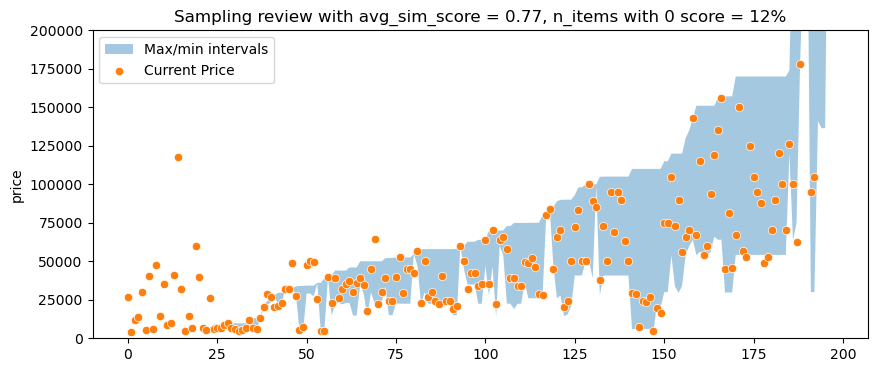

Market review for texts combination Title + cat:


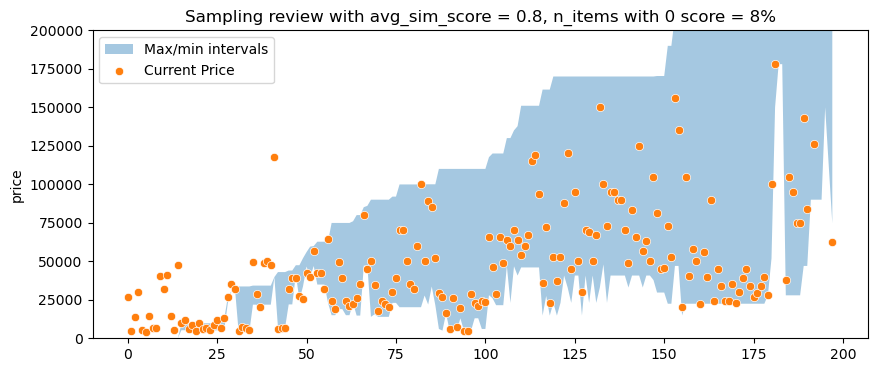

Market review for texts combination Cat + character:


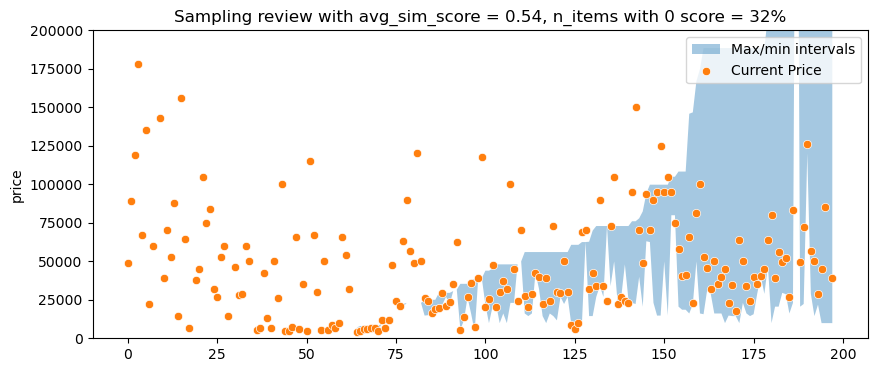

Market review for texts combination Title + character:


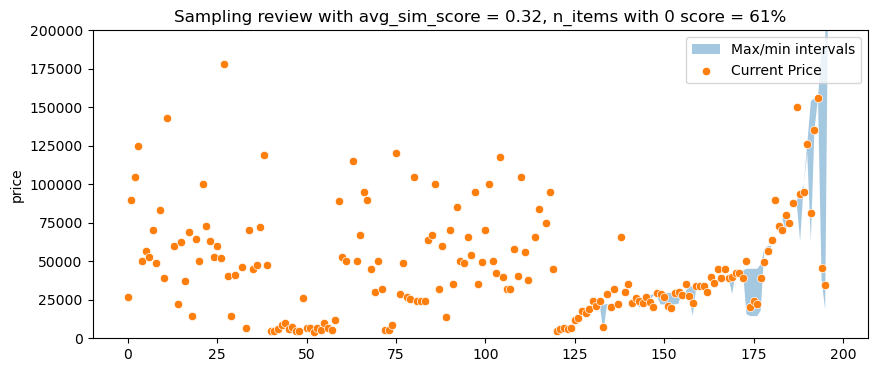

Market review for texts combination Only character:


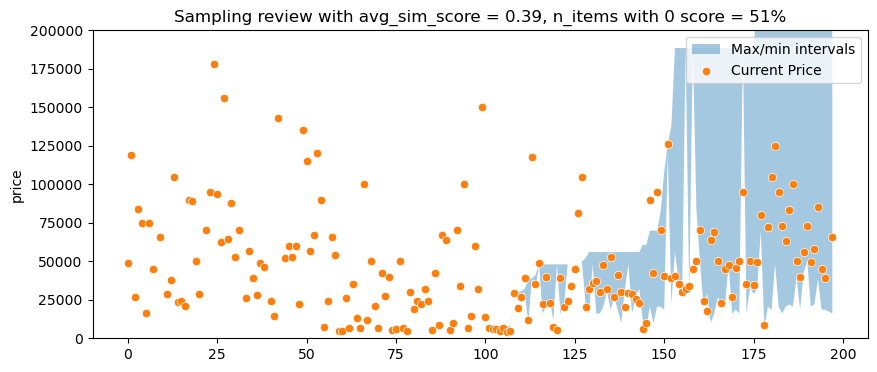

Market review for texts combination Title + cat + character:


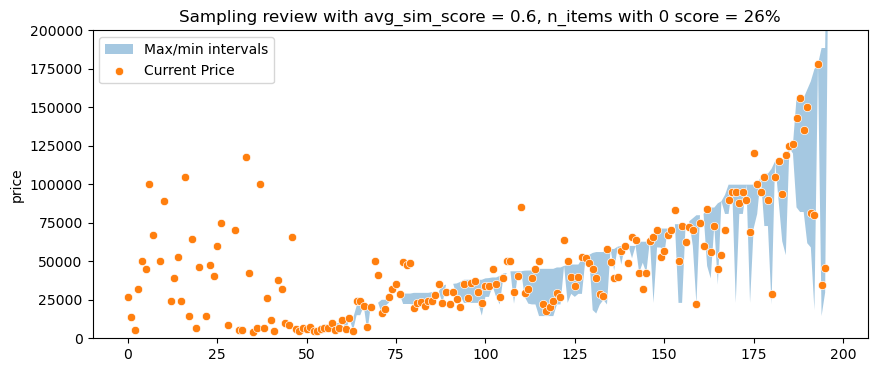

In [30]:
for ind, item  in enumerate(combo_names):
    print(f'Market review for texts combination {item}:')  
    market_review(data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0.79)

Market review for texts combination Title_only:


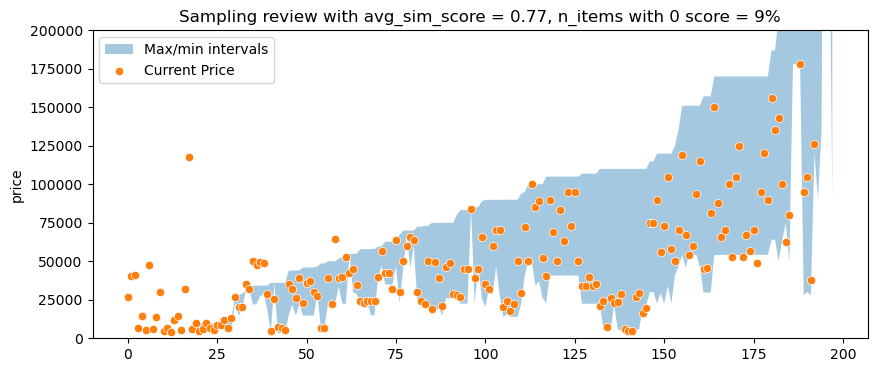

Market review for texts combination Title + cat:


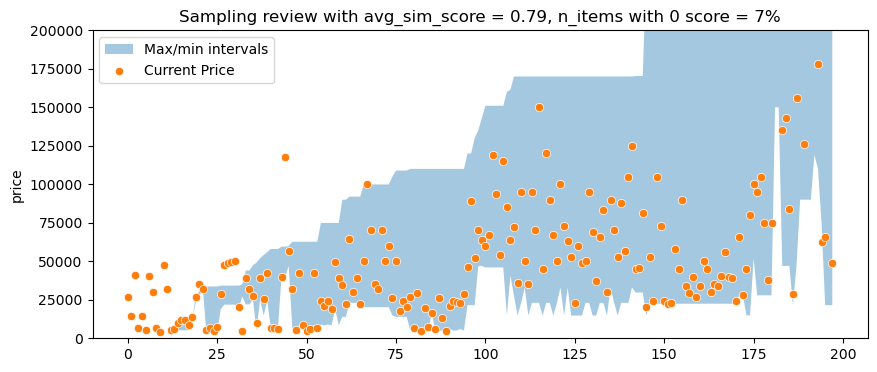

Market review for texts combination Cat + character:


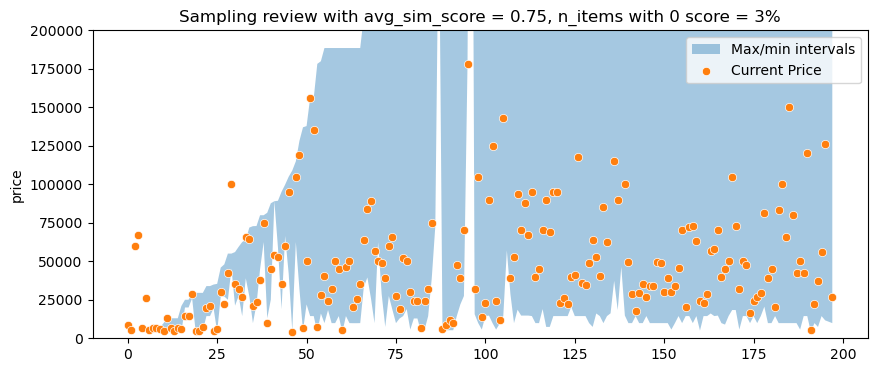

Market review for texts combination Title + character:


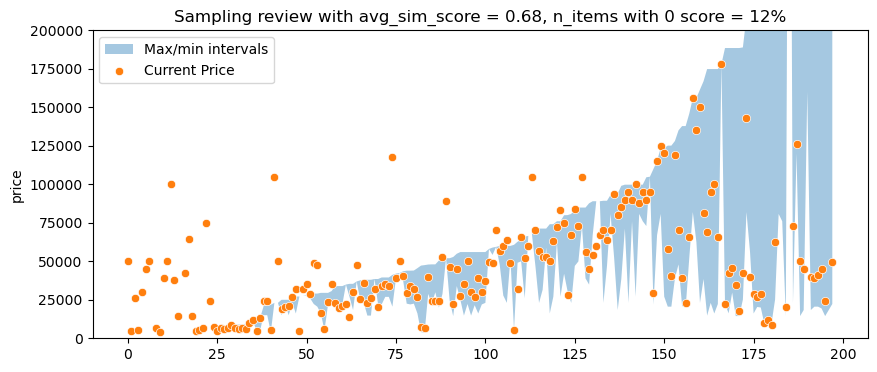

Market review for texts combination Only character:


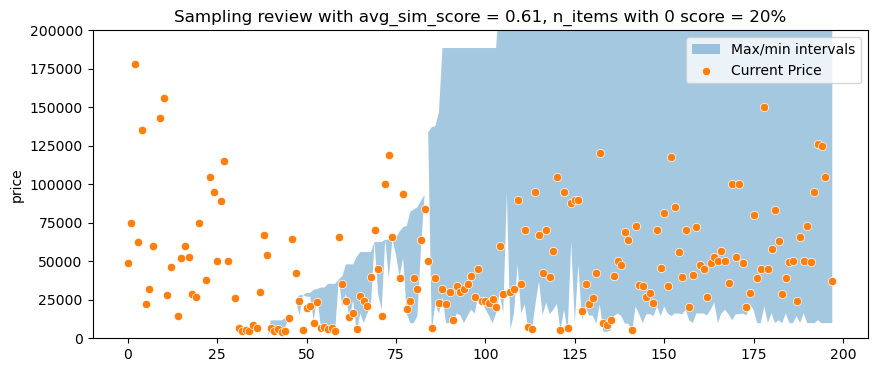

Market review for texts combination Title + cat + character:


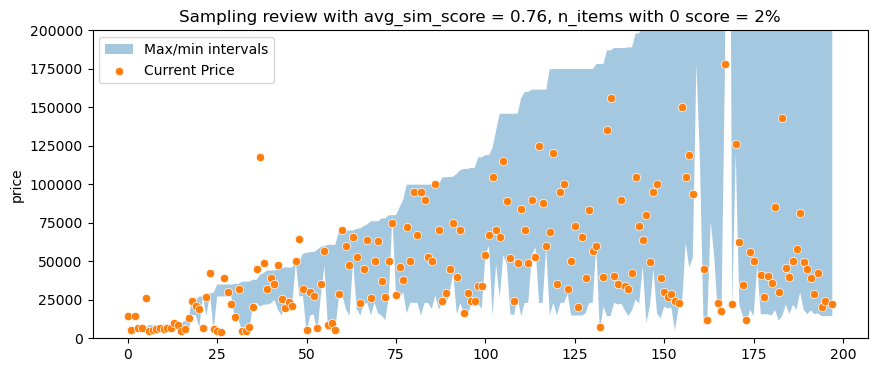

In [21]:
for ind, item  in enumerate(combo_names):
    print(f'Market review for texts combination {item}:')  
    market_review(data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0.75)

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor


def group_price_pred(model, data, competitors, data_vect, competitors_vect, sim_threshhold):
            """data - dataframe with own products
       competitors - dataframe with competitors' products
       data_vect - data in vectorized form
       competitors_vect - competitors data in vectorized form
       sim_threshhold - min similarity score to be inlcuded in recommendation"""

    similar_items = []
    scores_total = []
    gr = data.copy()
    data_emb = sparse.csr_matrix(data_vect)
    competitors_emb = sparse.csr_matrix(competitors_vect)
    #print(f'Log: start to search for similar items with threshhold {sim_threshhold}...')
    
    for item in range(len(data)):
        similarity = cosine_similarity(data_emb[item], competitors_emb).flatten()
        ind = np.argwhere(similarity > sim_threshhold)
        if ind.shape[0] == 0:
            pass
        else:
            scores = similarity[similarity > sim_threshhold]
            scores_total.extend(scores)
            flat_list = [item for sublist in ind.tolist() for item in sublist]
            similar_items.extend(flat_list)
    group_ind = set(similar_items)
    
    group_avg_score = round(sum(scores_total)/len(scores_total),2)
    
    print(f'Total similar items for the group = {len(group_ind)}')
    
    if len(group_ind) <= len(data):
        print('Similar group is too small, prediction not possible!')
    else:
        X = competitors_emb[list(group_ind)]
        y = competitors['price'][list(group_ind)]
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
        #model = CatBoostRegressor(verbose=False)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        RMSE = round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
        new_row = {'RMSE':round(np.sqrt(mean_squared_error(y_test, y_pred)),2),
                   'R2_score': round(r2_score(y_test, y_pred),4)}
        
        print(f'Log: training done, results: {new_row}')
        
        X_val = data_emb
        y_val = model.predict(X_val)
        gr['pred_price'] = y_val
        
        gr = gr.sort_values(by = 'price')
        
        plt.figure(figsize = [10,4])
        plt.fill_between(y1 = gr['pred_price'] - RMSE,
                             y2 = gr['pred_price'] + RMSE,
                            x = np.linspace(0,len(gr), num = len(gr)).astype(int),
                            alpha = 0.2,
                            label = 'Conf intervals')
        sns.scatterplot(x = np.linspace(0,len(gr), num = len(gr)).astype(int),
                      y = gr['pred_price'], label = 'Prediction')
        sns.scatterplot(x = np.linspace(0,len(gr), num = len(gr)).astype(int),
                      y = gr['price'], label = 'Current Price')
        plt.legend(loc = 'best')
        plt.ylim(0,200000)
        plt.title(f'Price prediction based on similarity score, group_avg = {group_avg_score}, RMSE = {RMSE}')
        plt.show()

Price prediction for texts combination Title_only:
Total similar items for the group = 3687
Log: training done, results: {'RMSE': 135090.47, 'R2_score': 0.8111}


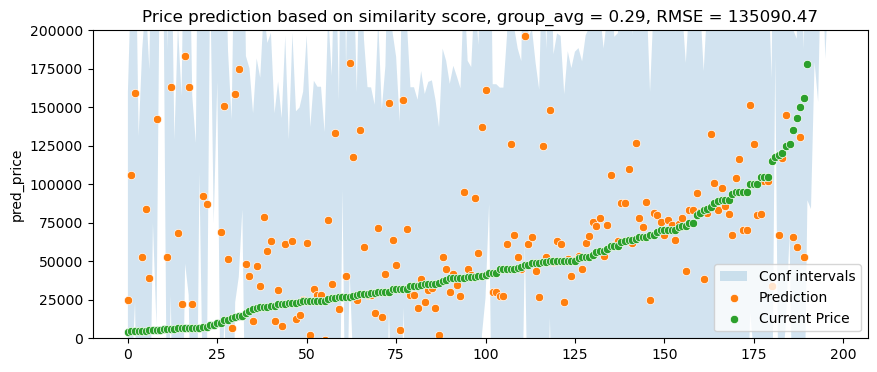

Price prediction for texts combination Title + cat:
Total similar items for the group = 3687
Log: training done, results: {'RMSE': 129642.79, 'R2_score': 0.826}


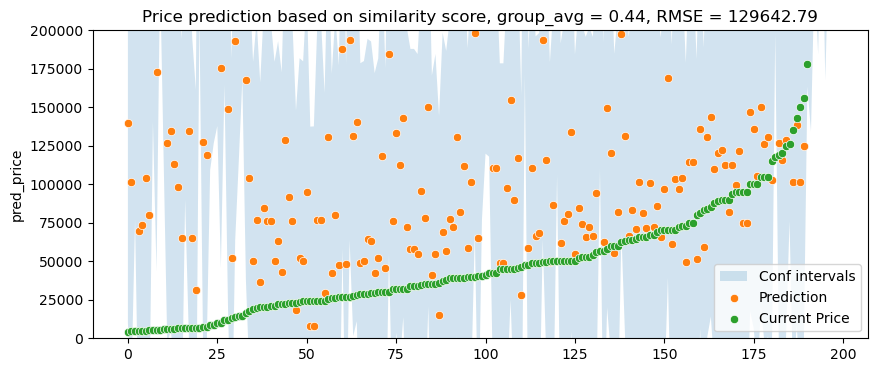

Price prediction for texts combination Cat + character:
Total similar items for the group = 3687
Log: training done, results: {'RMSE': 163741.11, 'R2_score': 0.7224}


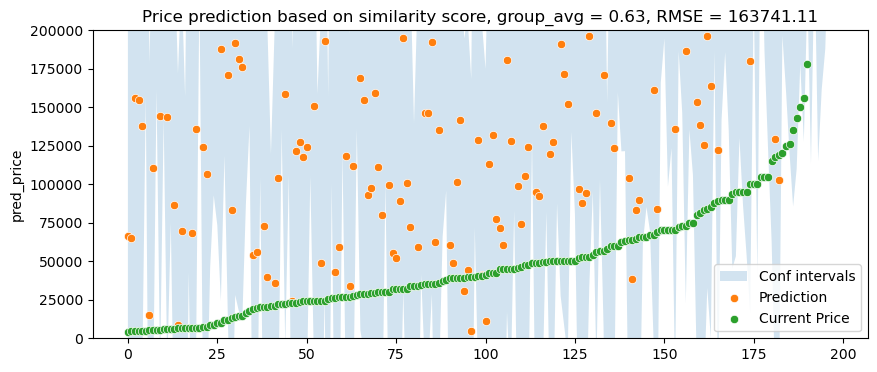

Price prediction for texts combination Title + character:
Total similar items for the group = 3687
Log: training done, results: {'RMSE': 162578.27, 'R2_score': 0.7264}


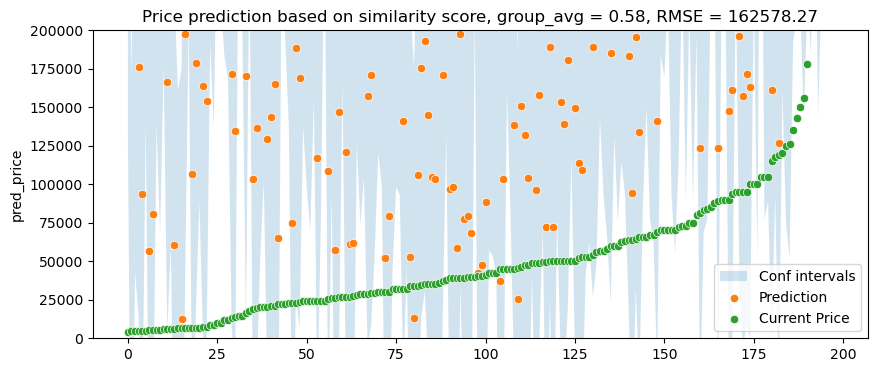

Price prediction for texts combination Only character:
Total similar items for the group = 3687
Log: training done, results: {'RMSE': 165876.27, 'R2_score': 0.7151}


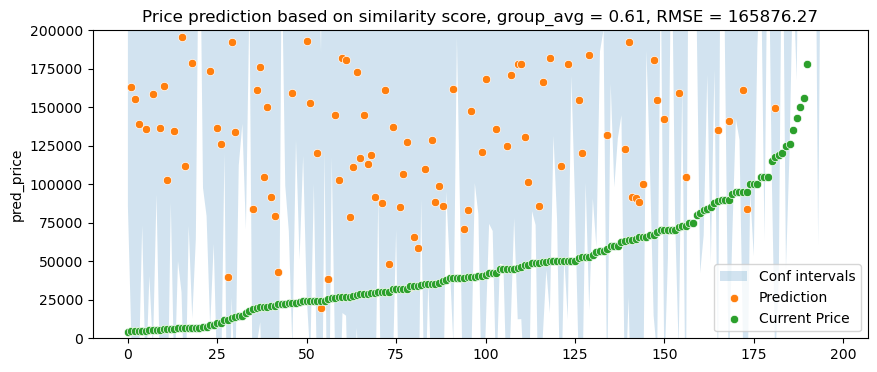

Price prediction for texts combination Title + cat + character:
Total similar items for the group = 3687
Log: training done, results: {'RMSE': 154740.57, 'R2_score': 0.7521}


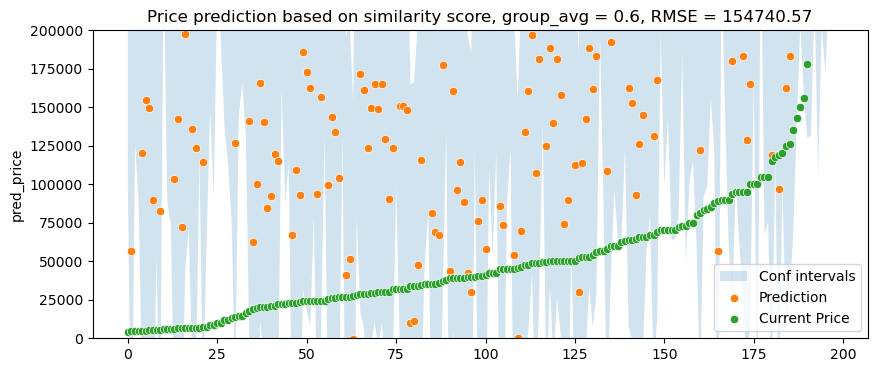

In [32]:
for ind, item  in enumerate(combo_names):
    print(f'Price prediction for texts combination {item}:')  
    group_price_pred(model = CatBoostRegressor(verbose=False),
               data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0)

Price prediction for texts combination Title_only:
Total similar items for the group = 988
Log: training done, results: {'RMSE': 18181.44, 'R2_score': 0.9535}


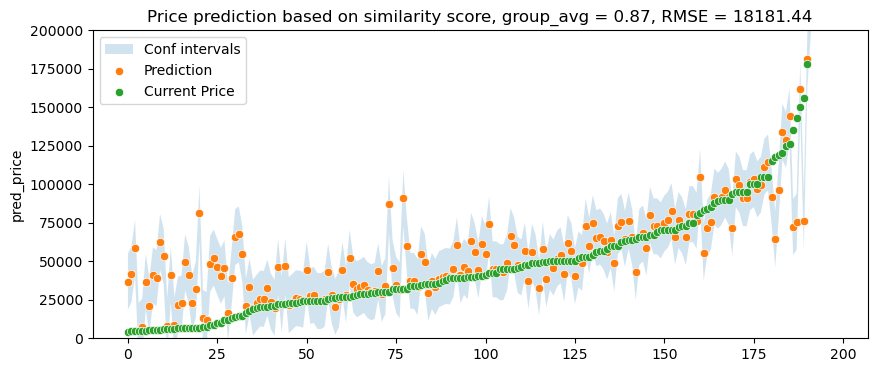

Price prediction for texts combination Title + cat:
Total similar items for the group = 1258
Log: training done, results: {'RMSE': 38911.27, 'R2_score': 0.8243}


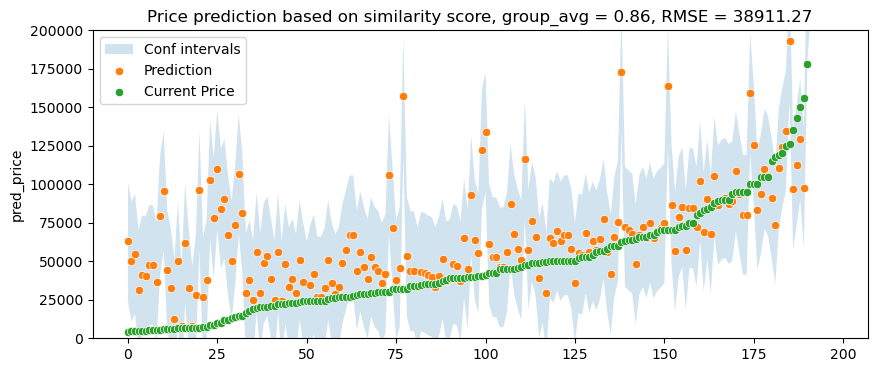

Price prediction for texts combination Cat + character:
Total similar items for the group = 228
Log: training done, results: {'RMSE': 142058.86, 'R2_score': 0.2052}


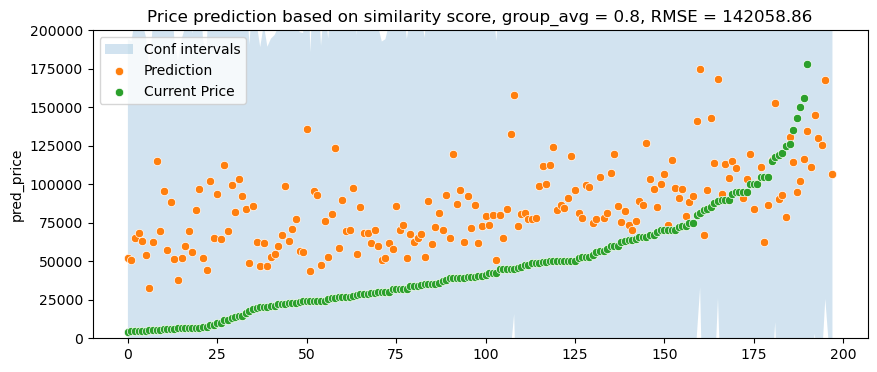

Price prediction for texts combination Title + character:
Total similar items for the group = 93
Similar group is too small, prediction not possible!
Price prediction for texts combination Only character:
Total similar items for the group = 128
Similar group is too small, prediction not possible!
Price prediction for texts combination Title + cat + character:
Total similar items for the group = 252
Log: training done, results: {'RMSE': 17205.65, 'R2_score': 0.7329}


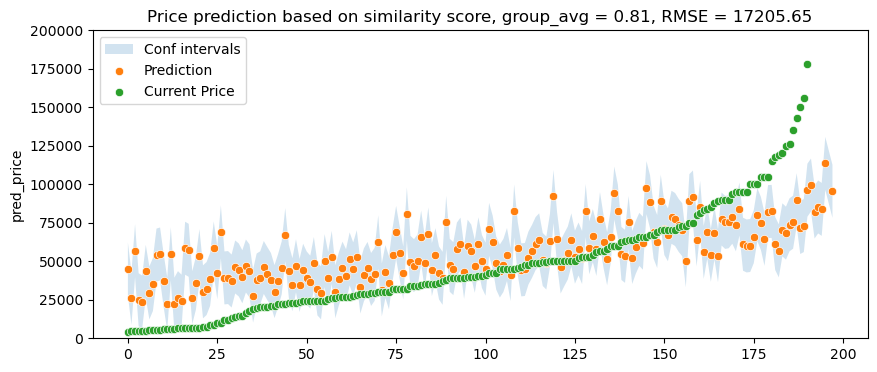

In [24]:
for ind, item  in enumerate(combo_names):
    print(f'Price prediction for texts combination {item}:')  
    group_price_pred(model = CatBoostRegressor(verbose=False),
               data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0.79)

Price prediction for texts combination Title_only:
Total similar items for the group = 988
Log: training done, results: {'RMSE': 28779.29, 'R2_score': 0.8835}


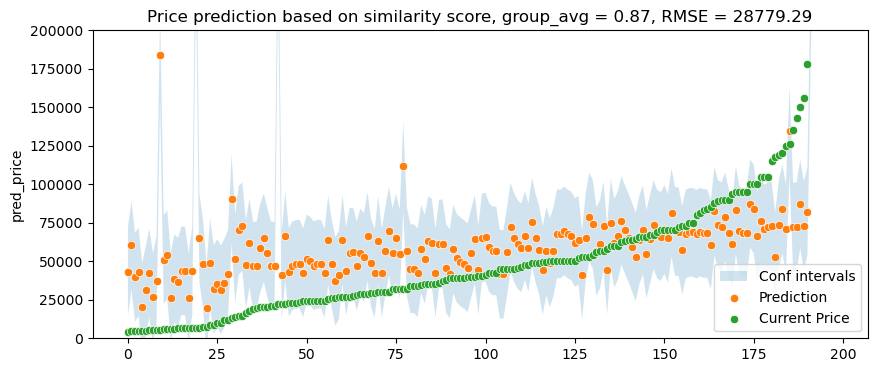

Price prediction for texts combination Title + cat:
Total similar items for the group = 1258
Log: training done, results: {'RMSE': 60350.46, 'R2_score': 0.5774}


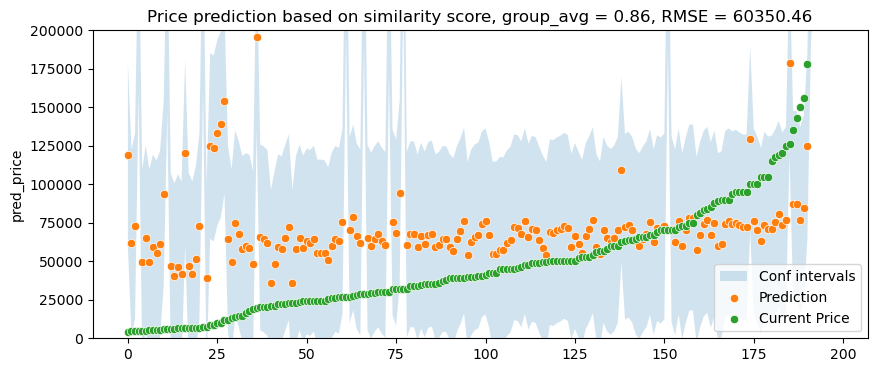

Price prediction for texts combination Cat + character:
Total similar items for the group = 228
Log: training done, results: {'RMSE': 139047.9, 'R2_score': 0.2385}


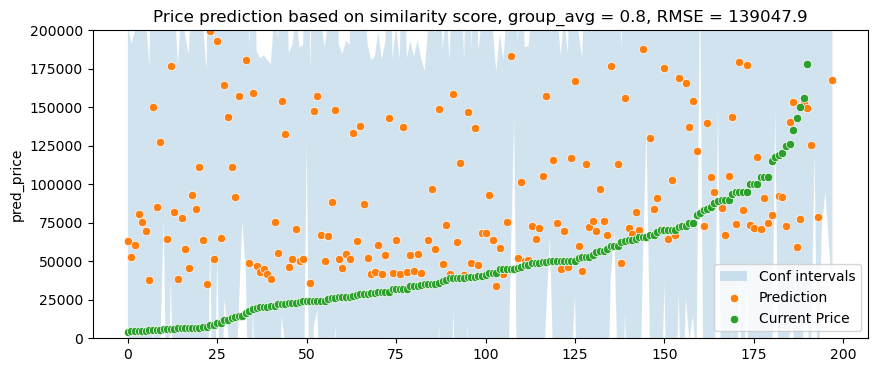

Price prediction for texts combination Title + character:
Total similar items for the group = 93
Similar group is too small, prediction not possible!
Price prediction for texts combination Only character:
Total similar items for the group = 128
Similar group is too small, prediction not possible!
Price prediction for texts combination Title + cat + character:
Total similar items for the group = 252
Log: training done, results: {'RMSE': 20982.15, 'R2_score': 0.6028}


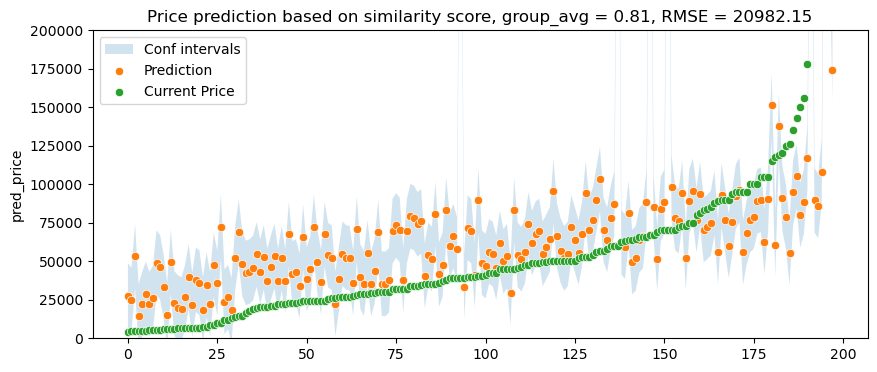

In [33]:
for ind, item  in enumerate(combo_names):
    print(f'Price prediction for texts combination {item}:')  
    group_price_pred(model = XGBRFRegressor(),
               data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0.79)


Price prediction for texts combination Title_only:
Total similar items for the group = 988
Log: training done, results: {'RMSE': 22472.9, 'R2_score': 0.929}


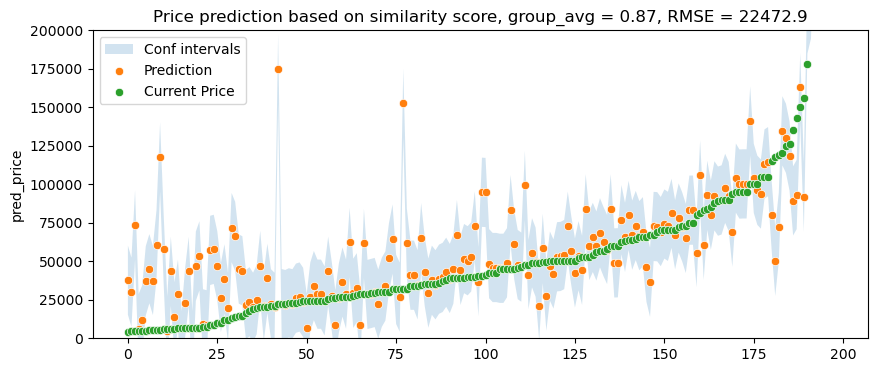

Price prediction for texts combination Title + cat:
Total similar items for the group = 1258
Log: training done, results: {'RMSE': 44398.93, 'R2_score': 0.7713}


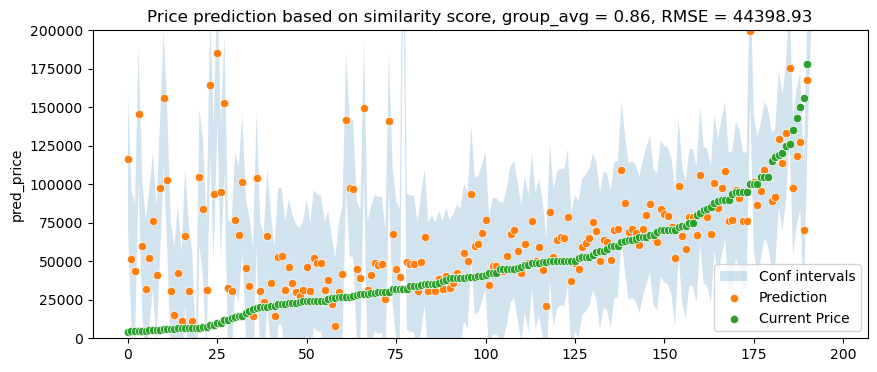

Price prediction for texts combination Cat + character:
Total similar items for the group = 228
Log: training done, results: {'RMSE': 119136.92, 'R2_score': 0.441}


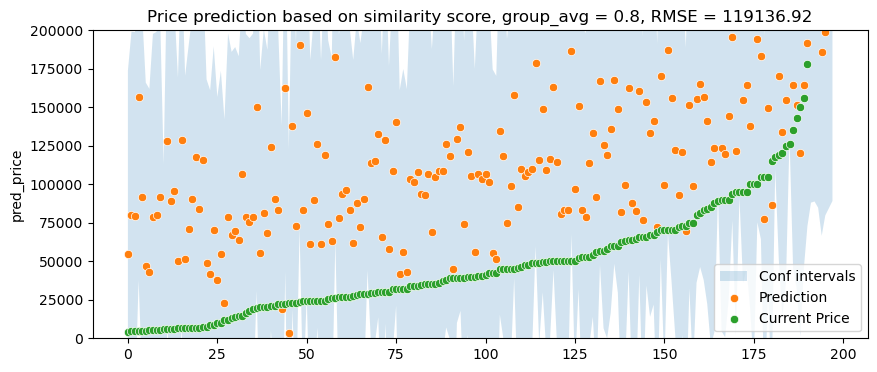

Price prediction for texts combination Title + character:
Total similar items for the group = 93
Similar group is too small, prediction not possible!
Price prediction for texts combination Only character:
Total similar items for the group = 128
Similar group is too small, prediction not possible!
Price prediction for texts combination Title + cat + character:
Total similar items for the group = 252
Log: training done, results: {'RMSE': 21338.4, 'R2_score': 0.5892}


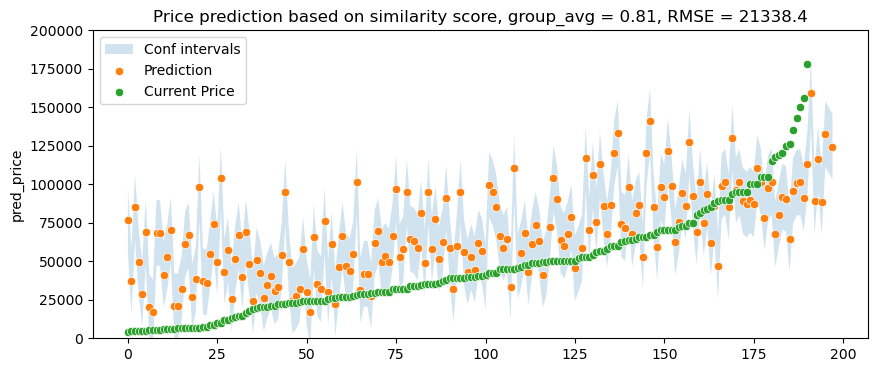

In [35]:
for ind, item  in enumerate(combo_names):
    print(f'Price prediction for texts combination {item}:')  
    group_price_pred(model = LGBMRegressor(),
               data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0.79)